In [1]:
import pandas as pd
import torch as t
import numpy as np
import os 
import matplotlib.pyplot as plt
from scipy import ndimage
import random
from tqdm import tqdm
from PIL import Image

In [2]:
device = t.device('cuda')

In [3]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

In [4]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device, dtype=t.float).unsqueeze(0)
def get_moore_nbh(batch:t.Tensor):
    _, batch_height, _ = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1) + MOORE_OFFSETS).flatten(end_dim=1)
    idx_pad = cell_pixel_coords[:, 0].repeat_interleave(9).flatten().unsqueeze(-1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    idc, counts = t.unique(idx_pad, return_counts=True)
    return t.split(t.concatenate((idx_pad, nbh_coords), dim=-1), split_size_or_sections=counts.tolist())

In [5]:
STEP_SIZES = t.tensor([(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)], device=device)
def MCS(batch, p_update):
    batch_size, batch_height, _ = batch.shape
    
    #########################################################
    # 1. Find source and target coordinates for each sample #
    #########################################################
    # Find all pixels that belong to a cell, or border a cell 
    frontiers = get_moore_nbh(batch)
    src_coords = t.vstack(list(map(random.choice, frontiers))).type(t.long)
    
    step_size_idx = t.tensor(np.random.choice(
            STEP_SIZES.shape[0],
            size=src_coords.shape[0],
            replace=True,
    )).type(t.long)
    step_sizes = STEP_SIZES[step_size_idx]
    tgt_coords = t.hstack((src_coords[:, 0].unsqueeze(0).T, src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = src_coords[:, 0]
    src_j = src_coords[:, 1]
    src_k = src_coords[:, 2]
    
    #########################################################################
    # 2. Calculate the changes in volume that the copy attempts would cause #
    #########################################################################
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #########################################################
    # 3. Define boolean masks based on the volume changes   #
    #########################################################
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    #########################################################
    # 4. auto accept each attempt with negative vol. change #
    # that fulfills the hard volume constraint              #
    #########################################################
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
    ##################################################################
    # 5. stochastic update of the attempts with positive vol. change #
    ################################################################## 
    update_mask = t.logical_and(
        vol_change_positive_mask,
        sml_eq_two_mask
    )
    logit = t.log(t.hstack((p_update, (1-p_update))))
    batch_logits = logit.repeat((vol_changes[update_mask].shape[0],1))
    one_hot = t.nn.functional.gumbel_softmax(batch_logits, hard=True)
    
    upd_vals = one_hot[:, 0] * vol_changes[update_mask]
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch

In [9]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, p_update:t.Tensor, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, p_update)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    # one pixel is half of a micron, meaning that the number of pixels traveled needs to be divided by 2
    mean_distance = t.mean(distances)
    print(f"p_update: {p_update}, mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, p_update)[0]
    print(f"gradient: {grad}")
    return p_update - (eta * grad), grad, mean_distance, loss

In [7]:
temperature = t.tensor(1., device=device)
target_vol = 1.
batch = t.zeros(1,256,256, device=device)
batch[:,128,128] += 1

states = []
for i in tqdm(range(10_000)):
    batch = MCS(batch, temperature)
    if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM")
        break
    else:
        states.append(batch[0].detach().clone().cpu().numpy())

imgs = [Image.fromarray((1-state)*255) for state in states]
print(len(imgs))
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], fps=20)

100%|██████████| 10000/10000 [00:39<00:00, 250.43it/s]


10000


In [15]:
temp = t.tensor(0.01, device=device)
temp.requires_grad_()
ref = t.zeros(1,128,128, device=device)
ref[:,64,64] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 6.

grads = []
mean_distances = []
losses = []
temps = [temp.detach().cpu().numpy()]
for i in range(700):
    temp.requires_grad_()
    batch = t.zeros(200,128,128, device=device)
    batch[:,64,64] += 1
    temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, eta=1e-5, num_steps=500, target_distance=target_distance)
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())
    temps.append(temp.detach().cpu().numpy())

100%|██████████| 500/500 [00:05<00:00, 97.10it/s] 


p_update: 0.009999999776482582, mean distance: 0.38750000000000007
gradient: -2122.463623046875


100%|██████████| 500/500 [00:04<00:00, 104.08it/s]


p_update: 0.031224636361002922, mean distance: 1.1275
gradient: -801.5249633789062


100%|██████████| 500/500 [00:04<00:00, 103.10it/s]


p_update: 0.03923988714814186, mean distance: 1.3775
gradient: -578.2583618164062


100%|██████████| 500/500 [00:04<00:00, 104.86it/s]


p_update: 0.04502246901392937, mean distance: 1.7925
gradient: -297.46380615234375


100%|██████████| 500/500 [00:04<00:00, 103.73it/s]


p_update: 0.04799710586667061, mean distance: 2.205
gradient: -210.82989501953125


100%|██████████| 500/500 [00:04<00:00, 104.78it/s]


p_update: 0.05010540410876274, mean distance: 1.96
gradient: -221.47828674316406


100%|██████████| 500/500 [00:04<00:00, 104.56it/s]


p_update: 0.05232018604874611, mean distance: 2.1825000000000006
gradient: -196.2967987060547


100%|██████████| 500/500 [00:04<00:00, 105.07it/s]


p_update: 0.054283153265714645, mean distance: 1.8675
gradient: -291.6898498535156


100%|██████████| 500/500 [00:04<00:00, 103.09it/s]


p_update: 0.057200051844120026, mean distance: 2.025
gradient: -275.49078369140625


100%|██████████| 500/500 [00:04<00:00, 104.60it/s]


p_update: 0.05995495989918709, mean distance: 2.2925
gradient: -91.40147399902344


100%|██████████| 500/500 [00:04<00:00, 105.65it/s]


p_update: 0.06086897477507591, mean distance: 2.2025
gradient: -214.77435302734375


100%|██████████| 500/500 [00:04<00:00, 105.68it/s]


p_update: 0.06301672011613846, mean distance: 2.3375
gradient: -101.41574096679688


100%|██████████| 500/500 [00:04<00:00, 105.91it/s]


p_update: 0.06403087824583054, mean distance: 2.4225
gradient: -56.47339630126953


100%|██████████| 500/500 [00:04<00:00, 106.22it/s]


p_update: 0.06459560990333557, mean distance: 2.54
gradient: -30.994205474853516


100%|██████████| 500/500 [00:04<00:00, 101.63it/s]


p_update: 0.0649055540561676, mean distance: 2.4775
gradient: -68.5616683959961


100%|██████████| 500/500 [00:04<00:00, 102.87it/s]


p_update: 0.06559117138385773, mean distance: 2.865
gradient: -20.122339248657227


100%|██████████| 500/500 [00:04<00:00, 104.64it/s]


p_update: 0.06579239666461945, mean distance: 2.5425
gradient: -86.05406951904297


100%|██████████| 500/500 [00:04<00:00, 104.44it/s]


p_update: 0.06665293872356415, mean distance: 2.735
gradient: -38.51704025268555


100%|██████████| 500/500 [00:04<00:00, 101.13it/s]


p_update: 0.06703811138868332, mean distance: 2.9925
gradient: 8.380215644836426


100%|██████████| 500/500 [00:04<00:00, 102.78it/s]


p_update: 0.06695430725812912, mean distance: 2.3275
gradient: -146.23306274414062


100%|██████████| 500/500 [00:04<00:00, 103.69it/s]


p_update: 0.06841664016246796, mean distance: 2.5075
gradient: -38.4002571105957


100%|██████████| 500/500 [00:04<00:00, 104.69it/s]


p_update: 0.06880064308643341, mean distance: 2.85
gradient: 83.71592712402344


100%|██████████| 500/500 [00:04<00:00, 103.81it/s]


p_update: 0.06796348094940186, mean distance: 2.4225
gradient: -86.30626678466797


100%|██████████| 500/500 [00:04<00:00, 102.31it/s]


p_update: 0.06882654130458832, mean distance: 2.54
gradient: -80.74586486816406


100%|██████████| 500/500 [00:04<00:00, 100.37it/s]


p_update: 0.06963399797677994, mean distance: 2.5100000000000002
gradient: -98.09213256835938


100%|██████████| 500/500 [00:04<00:00, 105.17it/s]


p_update: 0.07061491906642914, mean distance: 2.89
gradient: 29.912864685058594


100%|██████████| 500/500 [00:04<00:00, 102.35it/s]


p_update: 0.07031579315662384, mean distance: 2.2625
gradient: -162.90415954589844


100%|██████████| 500/500 [00:04<00:00, 103.06it/s]


p_update: 0.07194483280181885, mean distance: 2.895
gradient: 87.4289321899414


100%|██████████| 500/500 [00:04<00:00, 104.88it/s]


p_update: 0.07107054442167282, mean distance: 3.1125000000000003
gradient: 113.21892547607422


100%|██████████| 500/500 [00:04<00:00, 104.78it/s]


p_update: 0.06993835419416428, mean distance: 2.7325
gradient: 49.70402526855469


100%|██████████| 500/500 [00:04<00:00, 102.70it/s]


p_update: 0.0694413110613823, mean distance: 2.6750000000000003
gradient: -32.81754684448242


100%|██████████| 500/500 [00:04<00:00, 104.74it/s]


p_update: 0.069769486784935, mean distance: 2.6475
gradient: 23.314085006713867


100%|██████████| 500/500 [00:04<00:00, 103.36it/s]


p_update: 0.06953634321689606, mean distance: 2.735
gradient: 6.705360412597656


100%|██████████| 500/500 [00:04<00:00, 103.48it/s]


p_update: 0.06946928799152374, mean distance: 2.915
gradient: 0.709373950958252


100%|██████████| 500/500 [00:04<00:00, 103.75it/s]


p_update: 0.06946219503879547, mean distance: 3.1750000000000003
gradient: 110.7081298828125


100%|██████████| 500/500 [00:04<00:00, 103.29it/s]


p_update: 0.06835511326789856, mean distance: 2.85
gradient: -7.804378509521484


100%|██████████| 500/500 [00:04<00:00, 102.09it/s]


p_update: 0.06843315809965134, mean distance: 2.7600000000000002
gradient: -1.489100694656372


100%|██████████| 500/500 [00:04<00:00, 101.85it/s]


p_update: 0.06844805181026459, mean distance: 2.4925
gradient: -51.70326614379883


100%|██████████| 500/500 [00:04<00:00, 104.12it/s]


p_update: 0.06896508485078812, mean distance: 2.42
gradient: -23.143024444580078


100%|██████████| 500/500 [00:04<00:00, 105.29it/s]


p_update: 0.06919651478528976, mean distance: 2.8975
gradient: 6.838834762573242


100%|██████████| 500/500 [00:04<00:00, 104.50it/s]


p_update: 0.0691281259059906, mean distance: 2.8975
gradient: -1.5690717697143555


100%|██████████| 500/500 [00:04<00:00, 105.70it/s]


p_update: 0.06914381682872772, mean distance: 2.6425
gradient: -94.0558090209961


100%|██████████| 500/500 [00:04<00:00, 100.44it/s]


p_update: 0.07008437812328339, mean distance: 2.81
gradient: 46.44499969482422


100%|██████████| 500/500 [00:04<00:00, 105.93it/s]


p_update: 0.06961993128061295, mean distance: 2.4675000000000002
gradient: -87.42572784423828


100%|██████████| 500/500 [00:04<00:00, 104.30it/s]


p_update: 0.07049418985843658, mean distance: 2.4875000000000003
gradient: -87.93720245361328


100%|██████████| 500/500 [00:04<00:00, 105.13it/s]


p_update: 0.07137355953454971, mean distance: 2.7
gradient: -74.33174896240234


100%|██████████| 500/500 [00:04<00:00, 104.24it/s]


p_update: 0.07211687415838242, mean distance: 2.695
gradient: -50.47006607055664


100%|██████████| 500/500 [00:04<00:00, 103.38it/s]


p_update: 0.07262157648801804, mean distance: 2.6875
gradient: -2.0028936862945557


100%|██████████| 500/500 [00:04<00:00, 103.54it/s]


p_update: 0.07264160364866257, mean distance: 3.1575
gradient: 61.45195770263672


100%|██████████| 500/500 [00:04<00:00, 105.26it/s]


p_update: 0.07202708721160889, mean distance: 2.6825
gradient: 0.16913744807243347


100%|██████████| 500/500 [00:04<00:00, 103.27it/s]


p_update: 0.07202539592981339, mean distance: 2.5775
gradient: -51.564781188964844


100%|██████████| 500/500 [00:04<00:00, 101.36it/s]


p_update: 0.07254104316234589, mean distance: 2.6625
gradient: -11.890645027160645


100%|██████████| 500/500 [00:04<00:00, 103.22it/s]


p_update: 0.0726599469780922, mean distance: 3.0775
gradient: 93.29541015625


100%|██████████| 500/500 [00:04<00:00, 101.31it/s]


p_update: 0.07172699272632599, mean distance: 3.1025
gradient: 163.60887145996094


100%|██████████| 500/500 [00:04<00:00, 102.92it/s]


p_update: 0.07009090483188629, mean distance: 3.1075
gradient: 84.9676513671875


100%|██████████| 500/500 [00:04<00:00, 104.26it/s]


p_update: 0.0692412257194519, mean distance: 3.0875
gradient: 93.03460693359375


100%|██████████| 500/500 [00:04<00:00, 101.18it/s]


p_update: 0.06831087917089462, mean distance: 3.015
gradient: 91.32728576660156


100%|██████████| 500/500 [00:04<00:00, 103.20it/s]


p_update: 0.06739760935306549, mean distance: 2.7075
gradient: -11.561771392822266


100%|██████████| 500/500 [00:04<00:00, 103.61it/s]


p_update: 0.06751322746276855, mean distance: 2.6525
gradient: -44.826805114746094


100%|██████████| 500/500 [00:04<00:00, 104.42it/s]


p_update: 0.06796149909496307, mean distance: 2.6975000000000002
gradient: -9.312786102294922


100%|██████████| 500/500 [00:04<00:00, 100.95it/s]


p_update: 0.06805462390184402, mean distance: 2.37
gradient: -118.94819641113281


100%|██████████| 500/500 [00:04<00:00, 102.76it/s]


p_update: 0.06924410909414291, mean distance: 2.785
gradient: 36.712493896484375


100%|██████████| 500/500 [00:04<00:00, 103.57it/s]


p_update: 0.06887698173522949, mean distance: 2.92
gradient: 18.556978225708008


100%|██████████| 500/500 [00:04<00:00, 104.86it/s]


p_update: 0.06869141012430191, mean distance: 2.9375
gradient: 45.51515197753906


100%|██████████| 500/500 [00:04<00:00, 103.15it/s]


p_update: 0.06823626160621643, mean distance: 2.745
gradient: 18.979114532470703


100%|██████████| 500/500 [00:04<00:00, 102.71it/s]


p_update: 0.06804647296667099, mean distance: 2.66
gradient: -37.8452033996582


100%|██████████| 500/500 [00:04<00:00, 104.04it/s]


p_update: 0.06842492520809174, mean distance: 3.06
gradient: 51.12818908691406


100%|██████████| 500/500 [00:04<00:00, 102.93it/s]


p_update: 0.06791364401578903, mean distance: 2.3825
gradient: -61.451942443847656


100%|██████████| 500/500 [00:04<00:00, 102.91it/s]


p_update: 0.06852816045284271, mean distance: 2.9225
gradient: 27.93934440612793


100%|██████████| 500/500 [00:04<00:00, 102.43it/s]


p_update: 0.06824876368045807, mean distance: 2.69
gradient: -58.04999542236328


100%|██████████| 500/500 [00:04<00:00, 103.20it/s]


p_update: 0.0688292607665062, mean distance: 2.4225
gradient: -63.5295295715332


100%|██████████| 500/500 [00:04<00:00, 105.09it/s]


p_update: 0.0694645568728447, mean distance: 2.835
gradient: -14.972951889038086


100%|██████████| 500/500 [00:04<00:00, 104.09it/s]


p_update: 0.06961428374052048, mean distance: 2.5225
gradient: -13.357348442077637


100%|██████████| 500/500 [00:04<00:00, 104.95it/s]


p_update: 0.06974785774946213, mean distance: 2.33
gradient: -91.19247436523438


100%|██████████| 500/500 [00:04<00:00, 102.25it/s]


p_update: 0.07065977901220322, mean distance: 3.0700000000000003
gradient: 105.30652618408203


100%|██████████| 500/500 [00:04<00:00, 102.25it/s]


p_update: 0.069606713950634, mean distance: 2.795
gradient: 20.360410690307617


100%|██████████| 500/500 [00:04<00:00, 105.61it/s]


p_update: 0.06940311193466187, mean distance: 2.9525
gradient: 65.05358123779297


100%|██████████| 500/500 [00:04<00:00, 103.61it/s]


p_update: 0.06875257939100266, mean distance: 2.56
gradient: -113.02941131591797


100%|██████████| 500/500 [00:04<00:00, 102.41it/s]


p_update: 0.06988286972045898, mean distance: 2.6275
gradient: -54.67524337768555


100%|██████████| 500/500 [00:04<00:00, 101.85it/s]


p_update: 0.07042962312698364, mean distance: 2.765
gradient: 9.223424911499023


100%|██████████| 500/500 [00:04<00:00, 101.46it/s]


p_update: 0.07033739238977432, mean distance: 2.6350000000000002
gradient: -76.44930267333984


100%|██████████| 500/500 [00:04<00:00, 104.29it/s]


p_update: 0.07110188901424408, mean distance: 3.2625
gradient: 109.58993530273438


100%|██████████| 500/500 [00:04<00:00, 104.54it/s]


p_update: 0.07000599056482315, mean distance: 2.8475
gradient: -27.68236541748047


100%|██████████| 500/500 [00:04<00:00, 104.24it/s]


p_update: 0.07028281688690186, mean distance: 2.665
gradient: -11.268706321716309


100%|██████████| 500/500 [00:04<00:00, 103.34it/s]


p_update: 0.07039550691843033, mean distance: 2.9325
gradient: 32.39418029785156


100%|██████████| 500/500 [00:04<00:00, 105.28it/s]


p_update: 0.07007156312465668, mean distance: 2.8375
gradient: 27.747068405151367


100%|██████████| 500/500 [00:04<00:00, 102.75it/s]


p_update: 0.06979409605264664, mean distance: 2.195
gradient: -166.80032348632812


100%|██████████| 500/500 [00:04<00:00, 103.16it/s]


p_update: 0.07146210223436356, mean distance: 2.3775
gradient: -109.2585678100586


100%|██████████| 500/500 [00:04<00:00, 104.24it/s]


p_update: 0.07255468517541885, mean distance: 2.7675
gradient: 44.88853454589844


100%|██████████| 500/500 [00:05<00:00, 95.29it/s] 


p_update: 0.07210580259561539, mean distance: 2.7825
gradient: -30.70179557800293


100%|██████████| 500/500 [00:04<00:00, 103.51it/s]


p_update: 0.07241281867027283, mean distance: 3.185
gradient: 47.65310287475586


100%|██████████| 500/500 [00:04<00:00, 103.61it/s]


p_update: 0.07193628698587418, mean distance: 2.5125
gradient: -22.598962783813477


100%|██████████| 500/500 [00:04<00:00, 104.53it/s]


p_update: 0.07216227799654007, mean distance: 2.605
gradient: -81.6507339477539


100%|██████████| 500/500 [00:04<00:00, 104.75it/s]


p_update: 0.07297878712415695, mean distance: 2.6175
gradient: -83.4628677368164


100%|██████████| 500/500 [00:04<00:00, 102.53it/s]


p_update: 0.07381341606378555, mean distance: 2.98
gradient: 92.53718566894531


100%|██████████| 500/500 [00:04<00:00, 103.46it/s]


p_update: 0.07288804650306702, mean distance: 2.89
gradient: 21.545333862304688


100%|██████████| 500/500 [00:04<00:00, 101.80it/s]


p_update: 0.07267259061336517, mean distance: 2.16
gradient: -133.56605529785156


100%|██████████| 500/500 [00:04<00:00, 105.50it/s]


p_update: 0.07400824874639511, mean distance: 3.005
gradient: 26.618452072143555


100%|██████████| 500/500 [00:04<00:00, 102.90it/s]


p_update: 0.07374206185340881, mean distance: 3.1350000000000002
gradient: 76.90074920654297


100%|██████████| 500/500 [00:04<00:00, 102.70it/s]


p_update: 0.07297305762767792, mean distance: 2.79
gradient: -59.020751953125


100%|██████████| 500/500 [00:04<00:00, 104.04it/s]


p_update: 0.07356326282024384, mean distance: 3.34
gradient: 108.77647399902344


100%|██████████| 500/500 [00:04<00:00, 105.20it/s]


p_update: 0.07247550040483475, mean distance: 2.48
gradient: -79.609619140625


100%|██████████| 500/500 [00:04<00:00, 105.38it/s]


p_update: 0.07327159494161606, mean distance: 3.0475
gradient: 53.85424041748047


100%|██████████| 500/500 [00:04<00:00, 104.98it/s]


p_update: 0.07273305207490921, mean distance: 3.085
gradient: 56.458133697509766


100%|██████████| 500/500 [00:04<00:00, 103.93it/s]


p_update: 0.07216846942901611, mean distance: 2.7425
gradient: -22.319503784179688


100%|██████████| 500/500 [00:04<00:00, 102.36it/s]


p_update: 0.07239166647195816, mean distance: 2.7875
gradient: -26.439062118530273


100%|██████████| 500/500 [00:04<00:00, 104.52it/s]


p_update: 0.0726560577750206, mean distance: 3.0225
gradient: 28.26400375366211


100%|██████████| 500/500 [00:04<00:00, 105.34it/s]


p_update: 0.0723734200000763, mean distance: 2.5525
gradient: -57.857608795166016


100%|██████████| 500/500 [00:04<00:00, 102.73it/s]


p_update: 0.07295199483633041, mean distance: 2.8375
gradient: -1.348166823387146


100%|██████████| 500/500 [00:04<00:00, 105.92it/s]


p_update: 0.07296547293663025, mean distance: 3.16
gradient: 54.23375701904297


100%|██████████| 500/500 [00:04<00:00, 104.06it/s]


p_update: 0.07242313772439957, mean distance: 2.865
gradient: 7.688535213470459


100%|██████████| 500/500 [00:04<00:00, 104.20it/s]


p_update: 0.07234625518321991, mean distance: 2.4825
gradient: -72.27825164794922


100%|██████████| 500/500 [00:04<00:00, 105.62it/s]


p_update: 0.07306903600692749, mean distance: 2.9375
gradient: -8.48865032196045


100%|██████████| 500/500 [00:04<00:00, 103.27it/s]


p_update: 0.07315392047166824, mean distance: 2.5575
gradient: -0.43219196796417236


100%|██████████| 500/500 [00:04<00:00, 103.89it/s]


p_update: 0.07315824180841446, mean distance: 2.855
gradient: -1.3108930587768555


100%|██████████| 500/500 [00:04<00:00, 102.85it/s]


p_update: 0.07317134737968445, mean distance: 2.81
gradient: 11.990044593811035


100%|██████████| 500/500 [00:04<00:00, 104.09it/s]


p_update: 0.07305144518613815, mean distance: 3.0175
gradient: 82.07868194580078


100%|██████████| 500/500 [00:04<00:00, 103.34it/s]


p_update: 0.07223065942525864, mean distance: 2.71
gradient: 5.53233528137207


100%|██████████| 500/500 [00:04<00:00, 104.24it/s]


p_update: 0.07217533886432648, mean distance: 2.4250000000000003
gradient: -91.9549560546875


100%|██████████| 500/500 [00:04<00:00, 104.80it/s]


p_update: 0.07309488952159882, mean distance: 2.665
gradient: -22.580001831054688


100%|██████████| 500/500 [00:04<00:00, 104.11it/s]


p_update: 0.07332068681716919, mean distance: 2.74
gradient: 0.1401117742061615


100%|██████████| 500/500 [00:04<00:00, 103.92it/s]


p_update: 0.07331928610801697, mean distance: 3.1225
gradient: 77.13226318359375


100%|██████████| 500/500 [00:04<00:00, 103.02it/s]


p_update: 0.07254796475172043, mean distance: 2.955
gradient: 60.861698150634766


100%|██████████| 500/500 [00:04<00:00, 105.53it/s]


p_update: 0.07193934917449951, mean distance: 2.3725000000000005
gradient: -101.17115020751953


100%|██████████| 500/500 [00:04<00:00, 102.25it/s]


p_update: 0.0729510635137558, mean distance: 3.17
gradient: 78.45808410644531


100%|██████████| 500/500 [00:04<00:00, 103.68it/s]


p_update: 0.07216648012399673, mean distance: 2.6750000000000003
gradient: -37.52145767211914


100%|██████████| 500/500 [00:04<00:00, 102.64it/s]


p_update: 0.07254169136285782, mean distance: 2.955
gradient: 31.564374923706055


100%|██████████| 500/500 [00:04<00:00, 104.45it/s]


p_update: 0.07222604751586914, mean distance: 2.67
gradient: -62.890541076660156


100%|██████████| 500/500 [00:04<00:00, 104.44it/s]


p_update: 0.07285495102405548, mean distance: 2.8775
gradient: 2.4033589363098145


100%|██████████| 500/500 [00:04<00:00, 106.00it/s]


p_update: 0.0728309154510498, mean distance: 2.8025
gradient: 18.069900512695312


100%|██████████| 500/500 [00:04<00:00, 102.20it/s]


p_update: 0.07265021651983261, mean distance: 2.7600000000000002
gradient: -34.205570220947266


100%|██████████| 500/500 [00:04<00:00, 101.31it/s]


p_update: 0.07299227267503738, mean distance: 2.995
gradient: 33.620872497558594


100%|██████████| 500/500 [00:04<00:00, 101.48it/s]


p_update: 0.0726560652256012, mean distance: 3.0775
gradient: 57.11219787597656


100%|██████████| 500/500 [00:04<00:00, 105.21it/s]


p_update: 0.072084940969944, mean distance: 2.7175000000000002
gradient: 2.1701085567474365


100%|██████████| 500/500 [00:04<00:00, 103.96it/s]


p_update: 0.07206323742866516, mean distance: 2.535
gradient: -115.75255584716797


100%|██████████| 500/500 [00:04<00:00, 103.97it/s]


p_update: 0.07322075963020325, mean distance: 2.5175
gradient: -33.37474060058594


100%|██████████| 500/500 [00:04<00:00, 103.44it/s]


p_update: 0.07355450838804245, mean distance: 2.7375000000000003
gradient: 38.393131256103516


100%|██████████| 500/500 [00:04<00:00, 104.53it/s]


p_update: 0.07317057996988297, mean distance: 3.1575
gradient: 93.67902374267578


100%|██████████| 500/500 [00:04<00:00, 105.02it/s]


p_update: 0.07223378866910934, mean distance: 3.2975
gradient: 146.4517822265625


100%|██████████| 500/500 [00:04<00:00, 105.15it/s]


p_update: 0.07076927274465561, mean distance: 3.265
gradient: 112.03529357910156


100%|██████████| 500/500 [00:04<00:00, 102.99it/s]


p_update: 0.06964892148971558, mean distance: 2.5
gradient: -63.79545593261719


100%|██████████| 500/500 [00:04<00:00, 103.23it/s]


p_update: 0.07028687745332718, mean distance: 2.81
gradient: 35.58750534057617


100%|██████████| 500/500 [00:04<00:00, 103.68it/s]


p_update: 0.06993100047111511, mean distance: 2.5475
gradient: -46.344573974609375


100%|██████████| 500/500 [00:04<00:00, 104.23it/s]


p_update: 0.07039444893598557, mean distance: 2.715
gradient: 39.353092193603516


100%|██████████| 500/500 [00:04<00:00, 104.87it/s]


p_update: 0.07000091671943665, mean distance: 2.8975
gradient: 52.33357620239258


100%|██████████| 500/500 [00:04<00:00, 101.66it/s]


p_update: 0.06947758048772812, mean distance: 2.445
gradient: -48.09252166748047


100%|██████████| 500/500 [00:04<00:00, 103.45it/s]


p_update: 0.06995850801467896, mean distance: 2.82
gradient: -19.140270233154297


100%|██████████| 500/500 [00:04<00:00, 104.73it/s]


p_update: 0.07014991343021393, mean distance: 2.7125
gradient: -60.091129302978516


100%|██████████| 500/500 [00:04<00:00, 104.38it/s]


p_update: 0.07075082510709763, mean distance: 3.0025
gradient: 48.02158737182617


100%|██████████| 500/500 [00:04<00:00, 102.56it/s]


p_update: 0.0702706128358841, mean distance: 2.895
gradient: 30.339595794677734


100%|██████████| 500/500 [00:04<00:00, 101.92it/s]


p_update: 0.06996721774339676, mean distance: 2.8025
gradient: -33.17179870605469


100%|██████████| 500/500 [00:04<00:00, 105.71it/s]


p_update: 0.070298932492733, mean distance: 2.9225
gradient: 9.718094825744629


100%|██████████| 500/500 [00:04<00:00, 104.02it/s]


p_update: 0.07020175457000732, mean distance: 2.715
gradient: 4.8272199630737305


100%|██████████| 500/500 [00:04<00:00, 104.91it/s]


p_update: 0.07015348225831985, mean distance: 2.6475
gradient: 53.0049934387207


100%|██████████| 500/500 [00:04<00:00, 102.40it/s]


p_update: 0.0696234330534935, mean distance: 2.645
gradient: -50.936546325683594


100%|██████████| 500/500 [00:04<00:00, 102.86it/s]


p_update: 0.0701327994465828, mean distance: 2.6
gradient: -9.793009757995605


100%|██████████| 500/500 [00:04<00:00, 105.22it/s]


p_update: 0.07023072987794876, mean distance: 3.12
gradient: 104.16548156738281


100%|██████████| 500/500 [00:04<00:00, 104.83it/s]


p_update: 0.06918907165527344, mean distance: 3.08
gradient: 50.819541931152344


100%|██████████| 500/500 [00:04<00:00, 104.03it/s]


p_update: 0.06868087500333786, mean distance: 2.46
gradient: -81.17151641845703


100%|██████████| 500/500 [00:04<00:00, 104.93it/s]


p_update: 0.06949259340763092, mean distance: 3.105
gradient: 56.91374969482422


100%|██████████| 500/500 [00:04<00:00, 102.91it/s]


p_update: 0.0689234584569931, mean distance: 2.72
gradient: 13.177042007446289


100%|██████████| 500/500 [00:04<00:00, 105.30it/s]


p_update: 0.06879168748855591, mean distance: 2.715
gradient: -54.9500846862793


100%|██████████| 500/500 [00:04<00:00, 105.23it/s]


p_update: 0.06934119015932083, mean distance: 2.77
gradient: -22.604570388793945


100%|██████████| 500/500 [00:04<00:00, 102.55it/s]


p_update: 0.0695672333240509, mean distance: 2.8525
gradient: 36.9212760925293


100%|██████████| 500/500 [00:04<00:00, 102.74it/s]


p_update: 0.06919801980257034, mean distance: 2.965
gradient: 20.187023162841797


100%|██████████| 500/500 [00:04<00:00, 110.41it/s]


p_update: 0.06899614632129669, mean distance: 2.6925
gradient: -62.331268310546875


100%|██████████| 500/500 [00:04<00:00, 124.39it/s]


p_update: 0.06961946189403534, mean distance: 2.605
gradient: -52.3197021484375


100%|██████████| 500/500 [00:04<00:00, 122.31it/s]


p_update: 0.07014265656471252, mean distance: 2.975
gradient: 35.6220703125


100%|██████████| 500/500 [00:04<00:00, 124.30it/s]


p_update: 0.069786436855793, mean distance: 2.9775
gradient: 35.459163665771484


100%|██████████| 500/500 [00:04<00:00, 121.92it/s]


p_update: 0.0694318488240242, mean distance: 2.6
gradient: -75.80606079101562


100%|██████████| 500/500 [00:04<00:00, 122.92it/s]


p_update: 0.07018990814685822, mean distance: 2.3875
gradient: -73.0328140258789


100%|██████████| 500/500 [00:04<00:00, 124.97it/s]


p_update: 0.07092023640871048, mean distance: 2.6575
gradient: -42.55567932128906


100%|██████████| 500/500 [00:04<00:00, 124.22it/s]


p_update: 0.07134579122066498, mean distance: 2.7425
gradient: 4.045945644378662


100%|██████████| 500/500 [00:04<00:00, 122.94it/s]


p_update: 0.07130533456802368, mean distance: 2.5975
gradient: -47.976680755615234


100%|██████████| 500/500 [00:04<00:00, 124.15it/s]


p_update: 0.0717850998044014, mean distance: 2.64
gradient: -89.83731079101562


100%|██████████| 500/500 [00:04<00:00, 121.12it/s]


p_update: 0.07268347591161728, mean distance: 2.6425
gradient: -21.02755355834961


100%|██████████| 500/500 [00:03<00:00, 125.81it/s]


p_update: 0.07289375364780426, mean distance: 3.0475
gradient: 36.72589111328125


100%|██████████| 500/500 [00:04<00:00, 124.34it/s]


p_update: 0.0725264921784401, mean distance: 2.785
gradient: -57.78681945800781


100%|██████████| 500/500 [00:04<00:00, 122.15it/s]


p_update: 0.0731043592095375, mean distance: 3.2925
gradient: 37.31343078613281


100%|██████████| 500/500 [00:04<00:00, 123.32it/s]


p_update: 0.07273122668266296, mean distance: 3.1925
gradient: 81.30747985839844


100%|██████████| 500/500 [00:04<00:00, 124.74it/s]


p_update: 0.07191815227270126, mean distance: 2.5325
gradient: -56.108154296875


100%|██████████| 500/500 [00:04<00:00, 124.60it/s]


p_update: 0.0724792331457138, mean distance: 2.8175
gradient: 0.3181796371936798


100%|██████████| 500/500 [00:04<00:00, 122.68it/s]


p_update: 0.07247605174779892, mean distance: 2.86
gradient: -1.3316071033477783


100%|██████████| 500/500 [00:04<00:00, 123.63it/s]


p_update: 0.07248936593532562, mean distance: 3.3975
gradient: 69.57388305664062


100%|██████████| 500/500 [00:04<00:00, 123.10it/s]


p_update: 0.07179363071918488, mean distance: 2.5775
gradient: -142.83522033691406


100%|██████████| 500/500 [00:03<00:00, 125.37it/s]


p_update: 0.07322198152542114, mean distance: 2.49
gradient: -46.62767791748047


100%|██████████| 500/500 [00:04<00:00, 122.72it/s]


p_update: 0.07368826121091843, mean distance: 3.0625
gradient: 116.86711120605469


100%|██████████| 500/500 [00:04<00:00, 120.44it/s]


p_update: 0.07251959294080734, mean distance: 2.89
gradient: 23.738317489624023


100%|██████████| 500/500 [00:04<00:00, 120.43it/s]


p_update: 0.07228220999240875, mean distance: 2.9975
gradient: 49.95254135131836


100%|██████████| 500/500 [00:04<00:00, 121.06it/s]


p_update: 0.071782685816288, mean distance: 2.3925
gradient: -120.51563262939453


100%|██████████| 500/500 [00:04<00:00, 122.31it/s]


p_update: 0.07298783957958221, mean distance: 2.72
gradient: 14.930268287658691


100%|██████████| 500/500 [00:04<00:00, 124.29it/s]


p_update: 0.07283853739500046, mean distance: 3.0175
gradient: 32.268192291259766


100%|██████████| 500/500 [00:03<00:00, 125.35it/s]


p_update: 0.07251585274934769, mean distance: 2.84
gradient: -53.250572204589844


100%|██████████| 500/500 [00:04<00:00, 122.20it/s]


p_update: 0.07304836064577103, mean distance: 2.4475000000000002
gradient: -51.47362518310547


100%|██████████| 500/500 [00:04<00:00, 124.32it/s]


p_update: 0.0735630989074707, mean distance: 2.7075
gradient: -14.908379554748535


100%|██████████| 500/500 [00:04<00:00, 123.55it/s]


p_update: 0.07371218502521515, mean distance: 3.005
gradient: 0.48280370235443115


100%|██████████| 500/500 [00:04<00:00, 122.74it/s]


p_update: 0.07370735704898834, mean distance: 2.9025
gradient: 1.2671746015548706


100%|██████████| 500/500 [00:04<00:00, 116.72it/s]


p_update: 0.07369468361139297, mean distance: 2.6675
gradient: -42.20341873168945


100%|██████████| 500/500 [00:04<00:00, 123.57it/s]


p_update: 0.07411671429872513, mean distance: 3.495
gradient: 134.50645446777344


100%|██████████| 500/500 [00:03<00:00, 125.20it/s]


p_update: 0.07277165353298187, mean distance: 3.22
gradient: 101.67969512939453


100%|██████████| 500/500 [00:04<00:00, 124.18it/s]


p_update: 0.07175485789775848, mean distance: 2.7275
gradient: 33.28327178955078


100%|██████████| 500/500 [00:04<00:00, 124.49it/s]


p_update: 0.0714220255613327, mean distance: 2.57
gradient: -98.04019165039062


100%|██████████| 500/500 [00:04<00:00, 121.59it/s]


p_update: 0.07240242511034012, mean distance: 2.4625
gradient: -108.4688949584961


100%|██████████| 500/500 [00:04<00:00, 118.56it/s]


p_update: 0.07348711043596268, mean distance: 2.65
gradient: -66.23199462890625


100%|██████████| 500/500 [00:02<00:00, 189.90it/s]


p_update: 0.07414942979812622, mean distance: 2.955
gradient: 26.18804168701172


100%|██████████| 500/500 [00:04<00:00, 121.71it/s]


p_update: 0.07388754934072495, mean distance: 2.6925
gradient: -5.507091045379639


100%|██████████| 500/500 [00:04<00:00, 123.76it/s]


p_update: 0.07394261658191681, mean distance: 2.985
gradient: 48.10767364501953


100%|██████████| 500/500 [00:04<00:00, 121.16it/s]


p_update: 0.07346154004335403, mean distance: 3.045
gradient: 88.87713623046875


100%|██████████| 500/500 [00:04<00:00, 118.86it/s]


p_update: 0.07257276773452759, mean distance: 3.0775
gradient: 99.01964569091797


100%|██████████| 500/500 [00:04<00:00, 124.50it/s]


p_update: 0.07158257067203522, mean distance: 2.5775
gradient: -31.603578567504883


100%|██████████| 500/500 [00:04<00:00, 124.48it/s]


p_update: 0.07189860939979553, mean distance: 2.9375
gradient: 19.675552368164062


100%|██████████| 500/500 [00:03<00:00, 125.10it/s]


p_update: 0.07170185446739197, mean distance: 2.8425000000000002
gradient: -59.9083137512207


100%|██████████| 500/500 [00:04<00:00, 121.93it/s]


p_update: 0.07230094075202942, mean distance: 2.6425
gradient: -44.4990348815918


100%|██████████| 500/500 [00:04<00:00, 120.04it/s]


p_update: 0.07274593412876129, mean distance: 3.1225
gradient: 94.07952117919922


100%|██████████| 500/500 [00:04<00:00, 122.12it/s]


p_update: 0.07180514186620712, mean distance: 2.915
gradient: 80.6256103515625


100%|██████████| 500/500 [00:04<00:00, 123.45it/s]


p_update: 0.07099888473749161, mean distance: 2.545
gradient: -46.73969650268555


100%|██████████| 500/500 [00:04<00:00, 122.99it/s]


p_update: 0.07146628201007843, mean distance: 2.6225
gradient: -82.89275360107422


100%|██████████| 500/500 [00:04<00:00, 123.03it/s]


p_update: 0.07229521125555038, mean distance: 2.65
gradient: -57.577003479003906


100%|██████████| 500/500 [00:04<00:00, 123.83it/s]


p_update: 0.07287098467350006, mean distance: 3.0675
gradient: 8.108333587646484


100%|██████████| 500/500 [00:04<00:00, 121.85it/s]


p_update: 0.07278990000486374, mean distance: 2.6525
gradient: -42.8266487121582


100%|██████████| 500/500 [00:04<00:00, 124.60it/s]


p_update: 0.07321816682815552, mean distance: 2.6575
gradient: -29.371137619018555


100%|██████████| 500/500 [00:04<00:00, 123.65it/s]


p_update: 0.07351187616586685, mean distance: 3.2
gradient: 73.22464752197266


100%|██████████| 500/500 [00:03<00:00, 125.88it/s]


p_update: 0.07277963310480118, mean distance: 2.2
gradient: -188.07855224609375


100%|██████████| 500/500 [00:04<00:00, 122.11it/s]


p_update: 0.07466042041778564, mean distance: 2.395
gradient: -98.7258071899414


100%|██████████| 500/500 [00:04<00:00, 120.00it/s]


p_update: 0.07564768195152283, mean distance: 3.365
gradient: 98.10228729248047


100%|██████████| 500/500 [00:04<00:00, 123.91it/s]


p_update: 0.07466665655374527, mean distance: 2.5125
gradient: -50.04502487182617


100%|██████████| 500/500 [00:04<00:00, 124.48it/s]


p_update: 0.07516710460186005, mean distance: 2.98
gradient: 4.650135040283203


100%|██████████| 500/500 [00:04<00:00, 124.94it/s]


p_update: 0.07512060552835464, mean distance: 3.025
gradient: 34.56866455078125


100%|██████████| 500/500 [00:03<00:00, 125.54it/s]


p_update: 0.07477492094039917, mean distance: 2.88
gradient: -4.46096134185791


100%|██████████| 500/500 [00:04<00:00, 120.58it/s]


p_update: 0.07481952756643295, mean distance: 2.6975000000000002
gradient: -64.33940887451172


100%|██████████| 500/500 [00:03<00:00, 125.56it/s]


p_update: 0.07546292245388031, mean distance: 3.4250000000000003
gradient: 95.43558502197266


100%|██████████| 500/500 [00:04<00:00, 123.83it/s]


p_update: 0.07450857013463974, mean distance: 2.98
gradient: 65.91963958740234


100%|██████████| 500/500 [00:04<00:00, 119.92it/s]


p_update: 0.07384937256574631, mean distance: 2.765
gradient: -52.299659729003906


100%|██████████| 500/500 [00:04<00:00, 120.69it/s]


p_update: 0.07437236607074738, mean distance: 2.875
gradient: -25.798484802246094


100%|██████████| 500/500 [00:03<00:00, 125.35it/s]


p_update: 0.07463034987449646, mean distance: 2.775
gradient: -46.540733337402344


100%|██████████| 500/500 [00:04<00:00, 124.41it/s]


p_update: 0.0750957578420639, mean distance: 2.8575
gradient: 36.82211685180664


100%|██████████| 500/500 [00:03<00:00, 125.66it/s]


p_update: 0.07472753524780273, mean distance: 2.97
gradient: 53.2326545715332


100%|██████████| 500/500 [00:04<00:00, 121.33it/s]


p_update: 0.07419520616531372, mean distance: 3.31
gradient: 110.0647964477539


100%|██████████| 500/500 [00:04<00:00, 119.95it/s]


p_update: 0.07309456169605255, mean distance: 2.6325
gradient: -53.846923828125


100%|██████████| 500/500 [00:04<00:00, 124.39it/s]


p_update: 0.07363303005695343, mean distance: 2.72
gradient: -25.066537857055664


100%|██████████| 500/500 [00:04<00:00, 123.87it/s]


p_update: 0.07388369739055634, mean distance: 2.89
gradient: 21.756383895874023


100%|██████████| 500/500 [00:04<00:00, 121.70it/s]


p_update: 0.07366613298654556, mean distance: 2.7075
gradient: -47.414649963378906


100%|██████████| 500/500 [00:04<00:00, 124.70it/s]


p_update: 0.0741402804851532, mean distance: 2.8575
gradient: -31.314455032348633


100%|██████████| 500/500 [00:03<00:00, 125.51it/s]


p_update: 0.0744534283876419, mean distance: 3.11
gradient: 89.70806121826172


100%|██████████| 500/500 [00:04<00:00, 123.97it/s]


p_update: 0.07355634868144989, mean distance: 3.12
gradient: 82.2295150756836


100%|██████████| 500/500 [00:04<00:00, 123.06it/s]


p_update: 0.0727340504527092, mean distance: 2.73
gradient: -7.3857502937316895


100%|██████████| 500/500 [00:04<00:00, 122.59it/s]


p_update: 0.0728079080581665, mean distance: 3.515
gradient: 134.9502410888672


100%|██████████| 500/500 [00:04<00:00, 123.32it/s]


p_update: 0.07145840674638748, mean distance: 2.9
gradient: 73.72734069824219


100%|██████████| 500/500 [00:04<00:00, 121.45it/s]


p_update: 0.07072113454341888, mean distance: 2.715
gradient: 7.423464298248291


100%|██████████| 500/500 [00:04<00:00, 124.07it/s]


p_update: 0.07064689695835114, mean distance: 2.975
gradient: -20.37358856201172


100%|██████████| 500/500 [00:04<00:00, 123.63it/s]


p_update: 0.07085063308477402, mean distance: 2.6175
gradient: -20.277372360229492


100%|██████████| 500/500 [00:04<00:00, 120.94it/s]


p_update: 0.0710534080862999, mean distance: 3.1075
gradient: 44.0053825378418


100%|██████████| 500/500 [00:03<00:00, 126.25it/s]


p_update: 0.07061335444450378, mean distance: 2.845
gradient: 85.62117767333984


100%|██████████| 500/500 [00:04<00:00, 120.17it/s]


p_update: 0.0697571411728859, mean distance: 2.8925
gradient: 21.69120216369629


100%|██████████| 500/500 [00:03<00:00, 127.43it/s]


p_update: 0.06954023241996765, mean distance: 3.0375
gradient: 40.68628692626953


100%|██████████| 500/500 [00:03<00:00, 126.14it/s]


p_update: 0.06913337111473083, mean distance: 2.7775
gradient: -9.808283805847168


100%|██████████| 500/500 [00:03<00:00, 125.88it/s]


p_update: 0.06923145055770874, mean distance: 2.685
gradient: 29.37802505493164


100%|██████████| 500/500 [00:03<00:00, 125.41it/s]


p_update: 0.06893766671419144, mean distance: 2.7
gradient: -25.122568130493164


100%|██████████| 500/500 [00:03<00:00, 126.12it/s]


p_update: 0.06918889284133911, mean distance: 2.7875
gradient: -4.001780033111572


100%|██████████| 500/500 [00:04<00:00, 122.85it/s]


p_update: 0.06922890990972519, mean distance: 2.5775
gradient: -137.31735229492188


100%|██████████| 500/500 [00:03<00:00, 126.97it/s]


p_update: 0.07060208171606064, mean distance: 2.59
gradient: -48.06440734863281


100%|██████████| 500/500 [00:03<00:00, 125.14it/s]


p_update: 0.07108272612094879, mean distance: 2.8975
gradient: 17.90586280822754


100%|██████████| 500/500 [00:03<00:00, 125.77it/s]


p_update: 0.07090366631746292, mean distance: 2.7925
gradient: -0.8120202422142029


100%|██████████| 500/500 [00:03<00:00, 125.99it/s]


p_update: 0.07091178745031357, mean distance: 2.815
gradient: -12.598284721374512


100%|██████████| 500/500 [00:04<00:00, 120.19it/s]


p_update: 0.07103776931762695, mean distance: 2.66
gradient: -43.38716506958008


100%|██████████| 500/500 [00:03<00:00, 125.81it/s]


p_update: 0.07147163897752762, mean distance: 2.9175
gradient: 6.145661354064941


100%|██████████| 500/500 [00:03<00:00, 125.81it/s]


p_update: 0.0714101791381836, mean distance: 2.805
gradient: -10.577521324157715


100%|██████████| 500/500 [00:03<00:00, 125.35it/s]


p_update: 0.07151595503091812, mean distance: 3.295
gradient: 151.71685791015625


100%|██████████| 500/500 [00:03<00:00, 125.10it/s]


p_update: 0.06999878585338593, mean distance: 2.5300000000000002
gradient: -29.388620376586914


100%|██████████| 500/500 [00:03<00:00, 125.82it/s]


p_update: 0.07029267400503159, mean distance: 2.665
gradient: -57.56683349609375


100%|██████████| 500/500 [00:04<00:00, 124.93it/s]


p_update: 0.0708683431148529, mean distance: 2.24
gradient: -141.63180541992188


100%|██████████| 500/500 [00:04<00:00, 121.22it/s]


p_update: 0.07228466123342514, mean distance: 2.685
gradient: -59.62902069091797


100%|██████████| 500/500 [00:03<00:00, 125.20it/s]


p_update: 0.07288095355033875, mean distance: 2.955
gradient: 30.92879867553711


100%|██████████| 500/500 [00:03<00:00, 125.26it/s]


p_update: 0.07257166504859924, mean distance: 2.3975
gradient: -111.08656311035156


100%|██████████| 500/500 [00:03<00:00, 126.04it/s]


p_update: 0.07368253171443939, mean distance: 3.0025
gradient: 1.6194182634353638


100%|██████████| 500/500 [00:04<00:00, 124.76it/s]


p_update: 0.07366633415222168, mean distance: 3.08
gradient: 79.0911636352539


100%|██████████| 500/500 [00:04<00:00, 123.53it/s]


p_update: 0.07287542521953583, mean distance: 2.595
gradient: -59.773902893066406


100%|██████████| 500/500 [00:04<00:00, 123.85it/s]


p_update: 0.07347316294908524, mean distance: 2.8325
gradient: -3.9192612171173096


100%|██████████| 500/500 [00:03<00:00, 125.49it/s]


p_update: 0.07351235300302505, mean distance: 3.235
gradient: 81.7727279663086


100%|██████████| 500/500 [00:03<00:00, 126.96it/s]


p_update: 0.07269462943077087, mean distance: 2.915
gradient: 78.95000457763672


100%|██████████| 500/500 [00:03<00:00, 126.08it/s]


p_update: 0.07190512865781784, mean distance: 2.995
gradient: 51.45471954345703


100%|██████████| 500/500 [00:03<00:00, 125.26it/s]


p_update: 0.07139058411121368, mean distance: 2.3750000000000004
gradient: -154.36923217773438


100%|██████████| 500/500 [00:04<00:00, 124.70it/s]


p_update: 0.07293427735567093, mean distance: 3.065
gradient: 67.59760284423828


100%|██████████| 500/500 [00:03<00:00, 126.32it/s]


p_update: 0.07225830107927322, mean distance: 2.725
gradient: 5.840122222900391


100%|██████████| 500/500 [00:03<00:00, 125.31it/s]


p_update: 0.07219990342855453, mean distance: 2.7600000000000002
gradient: 18.351926803588867


100%|██████████| 500/500 [00:03<00:00, 126.44it/s]


p_update: 0.07201638072729111, mean distance: 2.2
gradient: -143.8435516357422


100%|██████████| 500/500 [00:04<00:00, 124.61it/s]


p_update: 0.07345481961965561, mean distance: 3.3475
gradient: 68.19283294677734


100%|██████████| 500/500 [00:03<00:00, 126.03it/s]


p_update: 0.07277289032936096, mean distance: 2.7225
gradient: -8.985957145690918


100%|██████████| 500/500 [00:03<00:00, 125.19it/s]


p_update: 0.07286275178194046, mean distance: 2.7475
gradient: -20.97351837158203


100%|██████████| 500/500 [00:04<00:00, 124.60it/s]


p_update: 0.07307248562574387, mean distance: 2.9475000000000002
gradient: 7.384913921356201


100%|██████████| 500/500 [00:03<00:00, 126.14it/s]


p_update: 0.07299863547086716, mean distance: 2.6550000000000002
gradient: -51.54863739013672


100%|██████████| 500/500 [00:04<00:00, 124.33it/s]


p_update: 0.07351411879062653, mean distance: 2.975
gradient: 46.2079963684082


100%|██████████| 500/500 [00:04<00:00, 121.27it/s]


p_update: 0.07305204123258591, mean distance: 3.1575
gradient: 83.25739288330078


100%|██████████| 500/500 [00:03<00:00, 125.61it/s]


p_update: 0.07221946865320206, mean distance: 2.87
gradient: 22.61399269104004


100%|██████████| 500/500 [00:04<00:00, 124.13it/s]


p_update: 0.07199332863092422, mean distance: 2.8850000000000002
gradient: 11.654340744018555


100%|██████████| 500/500 [00:04<00:00, 124.28it/s]


p_update: 0.07187678664922714, mean distance: 2.5875
gradient: -27.348915100097656


100%|██████████| 500/500 [00:03<00:00, 125.01it/s]


p_update: 0.07215027511119843, mean distance: 2.415
gradient: -117.97431182861328


100%|██████████| 500/500 [00:03<00:00, 125.41it/s]


p_update: 0.07333001494407654, mean distance: 3.0325
gradient: 65.70356750488281


100%|██████████| 500/500 [00:04<00:00, 121.49it/s]


p_update: 0.07267297804355621, mean distance: 2.8375
gradient: -7.986911773681641


100%|██████████| 500/500 [00:03<00:00, 126.05it/s]


p_update: 0.07275284826755524, mean distance: 2.65
gradient: -60.6917839050293


100%|██████████| 500/500 [00:04<00:00, 124.11it/s]


p_update: 0.07335976511240005, mean distance: 2.7025
gradient: -11.590885162353516


100%|██████████| 500/500 [00:03<00:00, 125.74it/s]


p_update: 0.0734756737947464, mean distance: 2.9250000000000003
gradient: 63.13357162475586


100%|██████████| 500/500 [00:04<00:00, 124.05it/s]


p_update: 0.07284434139728546, mean distance: 3.02
gradient: 16.15229034423828


100%|██████████| 500/500 [00:04<00:00, 123.46it/s]


p_update: 0.07268282026052475, mean distance: 2.39
gradient: -83.96014404296875


100%|██████████| 500/500 [00:04<00:00, 124.68it/s]


p_update: 0.0735224187374115, mean distance: 3.0325
gradient: 51.56806564331055


100%|██████████| 500/500 [00:04<00:00, 124.93it/s]


p_update: 0.07300674170255661, mean distance: 2.6175
gradient: -64.93675231933594


100%|██████████| 500/500 [00:04<00:00, 124.58it/s]


p_update: 0.0736561119556427, mean distance: 2.4575
gradient: -109.34757232666016


100%|██████████| 500/500 [00:04<00:00, 124.10it/s]


p_update: 0.07474958896636963, mean distance: 2.7175000000000002
gradient: -5.874054908752441


100%|██████████| 500/500 [00:04<00:00, 124.87it/s]


p_update: 0.07480832934379578, mean distance: 2.705
gradient: -55.291927337646484


100%|██████████| 500/500 [00:04<00:00, 124.54it/s]


p_update: 0.07536125183105469, mean distance: 2.81
gradient: -23.805675506591797


100%|██████████| 500/500 [00:03<00:00, 125.40it/s]


p_update: 0.075599305331707, mean distance: 3.245
gradient: 105.8252944946289


100%|██████████| 500/500 [00:04<00:00, 123.89it/s]


p_update: 0.07454105466604233, mean distance: 2.87
gradient: -22.342927932739258


100%|██████████| 500/500 [00:04<00:00, 124.22it/s]


p_update: 0.07476448267698288, mean distance: 2.96
gradient: 37.35735321044922


100%|██████████| 500/500 [00:03<00:00, 125.36it/s]


p_update: 0.07439091056585312, mean distance: 2.67
gradient: -41.6520881652832


100%|██████████| 500/500 [00:04<00:00, 118.99it/s]


p_update: 0.07480742782354355, mean distance: 2.7425
gradient: -9.45736026763916


100%|██████████| 500/500 [00:04<00:00, 122.98it/s]


p_update: 0.0749019980430603, mean distance: 2.8075
gradient: 13.537182807922363


100%|██████████| 500/500 [00:04<00:00, 123.62it/s]


p_update: 0.0747666284441948, mean distance: 2.6350000000000002
gradient: -64.822998046875


100%|██████████| 500/500 [00:04<00:00, 122.40it/s]


p_update: 0.07541485875844955, mean distance: 2.975
gradient: 26.10976219177246


100%|██████████| 500/500 [00:04<00:00, 123.77it/s]


p_update: 0.07515376061201096, mean distance: 3.0025
gradient: 5.125804901123047


100%|██████████| 500/500 [00:04<00:00, 124.27it/s]


p_update: 0.07510250061750412, mean distance: 3.18
gradient: 70.61227416992188


100%|██████████| 500/500 [00:04<00:00, 123.88it/s]


p_update: 0.07439637929201126, mean distance: 2.72
gradient: 0.18195316195487976


100%|██████████| 500/500 [00:03<00:00, 126.73it/s]


p_update: 0.07439456135034561, mean distance: 2.9875000000000003
gradient: 0.3189268708229065


100%|██████████| 500/500 [00:03<00:00, 126.37it/s]


p_update: 0.07439137250185013, mean distance: 2.7675
gradient: -18.7278995513916


100%|██████████| 500/500 [00:04<00:00, 123.73it/s]


p_update: 0.0745786502957344, mean distance: 2.7575
gradient: -19.590702056884766


100%|██████████| 500/500 [00:03<00:00, 127.22it/s]


p_update: 0.07477455586194992, mean distance: 2.8075
gradient: -5.7713236808776855


100%|██████████| 500/500 [00:03<00:00, 125.62it/s]


p_update: 0.07483226805925369, mean distance: 3.0725000000000002
gradient: 29.340131759643555


100%|██████████| 500/500 [00:03<00:00, 125.03it/s]


p_update: 0.07453886419534683, mean distance: 3.0575
gradient: 75.98025512695312


100%|██████████| 500/500 [00:04<00:00, 123.82it/s]


p_update: 0.07377906143665314, mean distance: 2.9575
gradient: -8.42630386352539


100%|██████████| 500/500 [00:03<00:00, 125.64it/s]


p_update: 0.07386332750320435, mean distance: 2.875
gradient: -21.299541473388672


100%|██████████| 500/500 [00:04<00:00, 124.05it/s]


p_update: 0.0740763247013092, mean distance: 3.0525
gradient: 40.27248001098633


100%|██████████| 500/500 [00:03<00:00, 125.97it/s]


p_update: 0.07367359846830368, mean distance: 2.6350000000000002
gradient: -68.40389251708984


100%|██████████| 500/500 [00:04<00:00, 123.54it/s]


p_update: 0.07435763627290726, mean distance: 2.625
gradient: -57.63112258911133


100%|██████████| 500/500 [00:04<00:00, 124.20it/s]


p_update: 0.07493394613265991, mean distance: 3.1
gradient: -9.878952026367188


100%|██████████| 500/500 [00:03<00:00, 125.40it/s]


p_update: 0.07503273338079453, mean distance: 2.815
gradient: -0.2925814092159271


100%|██████████| 500/500 [00:04<00:00, 123.41it/s]


p_update: 0.07503566145896912, mean distance: 2.8975
gradient: -1.6989307403564453


100%|██████████| 500/500 [00:03<00:00, 125.58it/s]


p_update: 0.0750526487827301, mean distance: 2.9775
gradient: 26.56136131286621


100%|██████████| 500/500 [00:04<00:00, 124.77it/s]


p_update: 0.07478703558444977, mean distance: 2.71
gradient: -39.3870849609375


100%|██████████| 500/500 [00:03<00:00, 126.06it/s]


p_update: 0.07518090307712555, mean distance: 2.9175
gradient: 43.26692581176758


100%|██████████| 500/500 [00:03<00:00, 125.16it/s]


p_update: 0.07474823296070099, mean distance: 2.545
gradient: -24.62519645690918


100%|██████████| 500/500 [00:04<00:00, 124.39it/s]


p_update: 0.07499448210000992, mean distance: 2.69
gradient: -23.584474563598633


100%|██████████| 500/500 [00:04<00:00, 119.28it/s]


p_update: 0.07523033022880554, mean distance: 2.9275
gradient: 32.124637603759766


100%|██████████| 500/500 [00:04<00:00, 124.82it/s]


p_update: 0.07490908354520798, mean distance: 3.0575
gradient: 87.19117736816406


100%|██████████| 500/500 [00:04<00:00, 121.99it/s]


p_update: 0.07403717190027237, mean distance: 3.0725000000000002
gradient: 31.467580795288086


100%|██████████| 500/500 [00:03<00:00, 125.24it/s]


p_update: 0.07372249662876129, mean distance: 2.8825
gradient: 20.97469139099121


100%|██████████| 500/500 [00:04<00:00, 124.39it/s]


p_update: 0.07351274788379669, mean distance: 3.16
gradient: 54.75112533569336


100%|██████████| 500/500 [00:03<00:00, 125.90it/s]


p_update: 0.07296523451805115, mean distance: 3.1975000000000002
gradient: 107.69121551513672


100%|██████████| 500/500 [00:03<00:00, 125.71it/s]


p_update: 0.07188832014799118, mean distance: 2.6925
gradient: -28.04975700378418


100%|██████████| 500/500 [00:04<00:00, 123.04it/s]


p_update: 0.07216881960630417, mean distance: 2.735
gradient: 58.23062515258789


100%|██████████| 500/500 [00:03<00:00, 125.32it/s]


p_update: 0.07158651202917099, mean distance: 2.4575
gradient: -70.76080322265625


100%|██████████| 500/500 [00:04<00:00, 123.71it/s]


p_update: 0.07229412347078323, mean distance: 2.5825
gradient: -32.37400436401367


100%|██████████| 500/500 [00:04<00:00, 124.30it/s]


p_update: 0.07261786609888077, mean distance: 2.415
gradient: -64.23043060302734


100%|██████████| 500/500 [00:04<00:00, 124.06it/s]


p_update: 0.07326017320156097, mean distance: 2.7325
gradient: -30.311227798461914


100%|██████████| 500/500 [00:04<00:00, 123.70it/s]


p_update: 0.07356328517198563, mean distance: 2.71
gradient: -36.75108337402344


100%|██████████| 500/500 [00:04<00:00, 121.47it/s]


p_update: 0.07393079251050949, mean distance: 3.13
gradient: 9.026923179626465


100%|██████████| 500/500 [00:04<00:00, 123.95it/s]


p_update: 0.07384052127599716, mean distance: 2.955
gradient: 7.792064189910889


100%|██████████| 500/500 [00:03<00:00, 125.59it/s]


p_update: 0.07376260310411453, mean distance: 2.91
gradient: 62.61850357055664


100%|██████████| 500/500 [00:04<00:00, 123.40it/s]


p_update: 0.07313641905784607, mean distance: 3.295
gradient: 125.67630767822266


100%|██████████| 500/500 [00:03<00:00, 125.87it/s]


p_update: 0.07187965512275696, mean distance: 2.7025
gradient: -19.898935317993164


100%|██████████| 500/500 [00:04<00:00, 122.08it/s]


p_update: 0.0720786452293396, mean distance: 2.98
gradient: 38.84888458251953


100%|██████████| 500/500 [00:04<00:00, 124.08it/s]


p_update: 0.0716901570558548, mean distance: 2.6025
gradient: -22.102785110473633


100%|██████████| 500/500 [00:04<00:00, 123.43it/s]


p_update: 0.07191118597984314, mean distance: 2.8825
gradient: 70.35702514648438


100%|██████████| 500/500 [00:03<00:00, 126.22it/s]


p_update: 0.07120761275291443, mean distance: 2.6725
gradient: -34.70996856689453


100%|██████████| 500/500 [00:03<00:00, 125.24it/s]


p_update: 0.07155471295118332, mean distance: 2.485
gradient: -83.6529769897461


100%|██████████| 500/500 [00:04<00:00, 122.61it/s]


p_update: 0.07239124178886414, mean distance: 3.295
gradient: 75.33921813964844


100%|██████████| 500/500 [00:04<00:00, 123.53it/s]


p_update: 0.0716378465294838, mean distance: 2.7700000000000005
gradient: 59.887664794921875


100%|██████████| 500/500 [00:03<00:00, 125.89it/s]


p_update: 0.07103896886110306, mean distance: 2.8925
gradient: 62.73739242553711


100%|██████████| 500/500 [00:03<00:00, 126.51it/s]


p_update: 0.07041159272193909, mean distance: 2.7775
gradient: -10.414713859558105


100%|██████████| 500/500 [00:04<00:00, 123.24it/s]


p_update: 0.07051573693752289, mean distance: 2.515
gradient: -39.701786041259766


100%|██████████| 500/500 [00:03<00:00, 125.67it/s]


p_update: 0.07091275602579117, mean distance: 2.7475
gradient: 21.60175323486328


100%|██████████| 500/500 [00:04<00:00, 123.49it/s]


p_update: 0.07069674134254456, mean distance: 2.5300000000000002
gradient: -52.287132263183594


100%|██████████| 500/500 [00:04<00:00, 123.24it/s]


p_update: 0.07121961563825607, mean distance: 2.5275
gradient: -87.6462631225586


100%|██████████| 500/500 [00:03<00:00, 126.16it/s]


p_update: 0.0720960795879364, mean distance: 2.8575
gradient: 19.290199279785156


100%|██████████| 500/500 [00:04<00:00, 124.91it/s]


p_update: 0.07190317660570145, mean distance: 2.73
gradient: -32.817745208740234


100%|██████████| 500/500 [00:03<00:00, 125.65it/s]


p_update: 0.07223135232925415, mean distance: 3.1075
gradient: 23.22626304626465


100%|██████████| 500/500 [00:03<00:00, 125.23it/s]


p_update: 0.07199908792972565, mean distance: 2.8725
gradient: 28.694517135620117


100%|██████████| 500/500 [00:04<00:00, 122.44it/s]


p_update: 0.07171214371919632, mean distance: 2.865
gradient: 16.00316047668457


100%|██████████| 500/500 [00:04<00:00, 124.30it/s]


p_update: 0.07155211269855499, mean distance: 3.215
gradient: 116.78609466552734


100%|██████████| 500/500 [00:03<00:00, 126.87it/s]


p_update: 0.07038424909114838, mean distance: 2.605
gradient: -58.135475158691406


100%|██████████| 500/500 [00:03<00:00, 125.88it/s]


p_update: 0.07096560299396515, mean distance: 2.6325
gradient: -13.260700225830078


100%|██████████| 500/500 [00:03<00:00, 126.34it/s]


p_update: 0.0710982084274292, mean distance: 2.845
gradient: 38.649078369140625


100%|██████████| 500/500 [00:04<00:00, 124.56it/s]


p_update: 0.07071171700954437, mean distance: 2.615
gradient: -27.597414016723633


100%|██████████| 500/500 [00:03<00:00, 125.91it/s]


p_update: 0.07098769396543503, mean distance: 2.75
gradient: 19.702455520629883


100%|██████████| 500/500 [00:03<00:00, 126.03it/s]


p_update: 0.07079067081212997, mean distance: 2.645
gradient: -14.094273567199707


100%|██████████| 500/500 [00:03<00:00, 126.39it/s]


p_update: 0.07093161344528198, mean distance: 2.6550000000000002
gradient: -46.49802780151367


100%|██████████| 500/500 [00:04<00:00, 122.84it/s]


p_update: 0.0713965967297554, mean distance: 3.08
gradient: 82.85948181152344


100%|██████████| 500/500 [00:04<00:00, 124.35it/s]


p_update: 0.07056800276041031, mean distance: 2.13
gradient: -132.49539184570312


100%|██████████| 500/500 [00:04<00:00, 121.42it/s]


p_update: 0.07189295440912247, mean distance: 2.3225000000000002
gradient: -153.2794189453125


100%|██████████| 500/500 [00:03<00:00, 125.81it/s]


p_update: 0.07342574745416641, mean distance: 2.935
gradient: 6.722667694091797


100%|██████████| 500/500 [00:03<00:00, 125.33it/s]


p_update: 0.07335852086544037, mean distance: 2.99
gradient: -19.629369735717773


100%|██████████| 500/500 [00:03<00:00, 125.12it/s]


p_update: 0.07355481386184692, mean distance: 3.3225000000000002
gradient: 70.74098205566406


100%|██████████| 500/500 [00:03<00:00, 127.05it/s]


p_update: 0.0728474035859108, mean distance: 2.89
gradient: 18.897127151489258


100%|██████████| 500/500 [00:03<00:00, 125.12it/s]


p_update: 0.07265843451023102, mean distance: 3.1575
gradient: 76.38191223144531


100%|██████████| 500/500 [00:04<00:00, 123.85it/s]


p_update: 0.07189461588859558, mean distance: 2.7125
gradient: -39.758480072021484


100%|██████████| 500/500 [00:04<00:00, 124.33it/s]


p_update: 0.07229220122098923, mean distance: 2.9675000000000002
gradient: 64.15418243408203


100%|██████████| 500/500 [00:04<00:00, 122.08it/s]


p_update: 0.0716506615281105, mean distance: 2.5225
gradient: -101.42637634277344


100%|██████████| 500/500 [00:04<00:00, 124.75it/s]


p_update: 0.07266492396593094, mean distance: 2.7875
gradient: 13.932394027709961


100%|██████████| 500/500 [00:04<00:00, 124.22it/s]


p_update: 0.07252559810876846, mean distance: 3.3125
gradient: 69.76316833496094


100%|██████████| 500/500 [00:04<00:00, 119.49it/s]


p_update: 0.0718279629945755, mean distance: 2.815
gradient: 56.039710998535156


100%|██████████| 500/500 [00:03<00:00, 127.46it/s]


p_update: 0.07126756757497787, mean distance: 2.9425
gradient: 6.244022369384766


100%|██████████| 500/500 [00:03<00:00, 126.05it/s]


p_update: 0.07120512425899506, mean distance: 3.14
gradient: 100.38002014160156


100%|██████████| 500/500 [00:03<00:00, 126.54it/s]


p_update: 0.0702013224363327, mean distance: 2.725
gradient: -27.211170196533203


100%|██████████| 500/500 [00:04<00:00, 124.36it/s]


p_update: 0.07047343254089355, mean distance: 2.6075
gradient: -13.050238609313965


100%|██████████| 500/500 [00:03<00:00, 126.41it/s]


p_update: 0.07060393691062927, mean distance: 2.585
gradient: -13.38638973236084


100%|██████████| 500/500 [00:03<00:00, 125.33it/s]


p_update: 0.0707378014922142, mean distance: 2.7175000000000002
gradient: -5.780751705169678


100%|██████████| 500/500 [00:03<00:00, 125.06it/s]


p_update: 0.07079561054706573, mean distance: 2.47
gradient: -70.98548126220703


100%|██████████| 500/500 [00:04<00:00, 124.98it/s]


p_update: 0.07150546461343765, mean distance: 2.98
gradient: -38.30442428588867


100%|██████████| 500/500 [00:03<00:00, 126.44it/s]


p_update: 0.0718885064125061, mean distance: 2.98
gradient: 70.03494262695312


100%|██████████| 500/500 [00:04<00:00, 123.27it/s]


p_update: 0.07118815928697586, mean distance: 2.52
gradient: 24.487577438354492


100%|██████████| 500/500 [00:04<00:00, 120.98it/s]


p_update: 0.07094328105449677, mean distance: 3.055
gradient: 64.03665924072266


100%|██████████| 500/500 [00:03<00:00, 126.83it/s]


p_update: 0.07030291110277176, mean distance: 2.7975
gradient: -37.095115661621094


100%|██████████| 500/500 [00:04<00:00, 123.46it/s]


p_update: 0.0706738606095314, mean distance: 2.9475000000000002
gradient: 65.974853515625


100%|██████████| 500/500 [00:04<00:00, 124.31it/s]


p_update: 0.0700141116976738, mean distance: 2.8375
gradient: 64.22502136230469


100%|██████████| 500/500 [00:04<00:00, 124.09it/s]


p_update: 0.06937186419963837, mean distance: 2.43
gradient: -103.02135467529297


100%|██████████| 500/500 [00:04<00:00, 124.51it/s]


p_update: 0.07040207833051682, mean distance: 2.5675
gradient: -27.341474533081055


100%|██████████| 500/500 [00:03<00:00, 126.60it/s]


p_update: 0.07067549228668213, mean distance: 3.2125
gradient: 54.990135192871094


100%|██████████| 500/500 [00:04<00:00, 123.70it/s]


p_update: 0.07012558728456497, mean distance: 2.465
gradient: -85.26117706298828


100%|██████████| 500/500 [00:03<00:00, 125.82it/s]


p_update: 0.07097820192575455, mean distance: 2.8575
gradient: 40.314964294433594


100%|██████████| 500/500 [00:03<00:00, 125.00it/s]


p_update: 0.070575051009655, mean distance: 2.6875
gradient: 27.286176681518555


100%|██████████| 500/500 [00:03<00:00, 125.65it/s]


p_update: 0.07030218839645386, mean distance: 2.52
gradient: -95.71012115478516


100%|██████████| 500/500 [00:04<00:00, 123.24it/s]


p_update: 0.07125928997993469, mean distance: 3.015
gradient: 49.142677307128906


100%|██████████| 500/500 [00:04<00:00, 124.82it/s]


p_update: 0.07076786458492279, mean distance: 2.5425
gradient: -81.1285171508789


100%|██████████| 500/500 [00:04<00:00, 122.71it/s]


p_update: 0.07157915085554123, mean distance: 2.8725
gradient: 28.61671257019043


100%|██████████| 500/500 [00:04<00:00, 121.55it/s]


p_update: 0.07129298150539398, mean distance: 2.835
gradient: -9.169118881225586


100%|██████████| 500/500 [00:03<00:00, 125.63it/s]


p_update: 0.07138467580080032, mean distance: 2.6875
gradient: -36.51832580566406


100%|██████████| 500/500 [00:03<00:00, 126.01it/s]


p_update: 0.07174985855817795, mean distance: 2.9675000000000002
gradient: 82.68184661865234


100%|██████████| 500/500 [00:04<00:00, 124.93it/s]


p_update: 0.07092303782701492, mean distance: 2.9250000000000003
gradient: 57.89421463012695


100%|██████████| 500/500 [00:03<00:00, 125.84it/s]


p_update: 0.07034409791231155, mean distance: 2.5675
gradient: -56.31907272338867


100%|██████████| 500/500 [00:04<00:00, 124.00it/s]


p_update: 0.07090728729963303, mean distance: 2.96
gradient: 49.750301361083984


100%|██████████| 500/500 [00:03<00:00, 125.57it/s]


p_update: 0.07040978223085403, mean distance: 2.9725
gradient: 79.71234893798828


100%|██████████| 500/500 [00:04<00:00, 123.50it/s]


p_update: 0.06961265951395035, mean distance: 2.415
gradient: -86.91504669189453


100%|██████████| 500/500 [00:04<00:00, 122.48it/s]


p_update: 0.0704818069934845, mean distance: 3.0375
gradient: 79.03389739990234


100%|██████████| 500/500 [00:04<00:00, 122.21it/s]


p_update: 0.06969146430492401, mean distance: 2.375
gradient: -81.80264282226562


100%|██████████| 500/500 [00:04<00:00, 124.65it/s]


p_update: 0.07050949335098267, mean distance: 2.8375
gradient: 22.41861343383789


100%|██████████| 500/500 [00:04<00:00, 122.38it/s]


p_update: 0.07028530538082123, mean distance: 2.4275
gradient: -145.90753173828125


100%|██████████| 500/500 [00:03<00:00, 127.46it/s]


p_update: 0.07174438238143921, mean distance: 3.1225
gradient: 92.08496856689453


100%|██████████| 500/500 [00:03<00:00, 125.58it/s]


p_update: 0.070823535323143, mean distance: 2.57
gradient: -53.78736114501953


100%|██████████| 500/500 [00:04<00:00, 123.45it/s]


p_update: 0.07136140763759613, mean distance: 2.99
gradient: 7.0096025466918945


100%|██████████| 500/500 [00:03<00:00, 125.66it/s]


p_update: 0.07129131257534027, mean distance: 2.6
gradient: -44.196441650390625


100%|██████████| 500/500 [00:04<00:00, 124.63it/s]


p_update: 0.0717332735657692, mean distance: 2.71
gradient: -23.45229148864746


100%|██████████| 500/500 [00:04<00:00, 124.53it/s]


p_update: 0.07196779549121857, mean distance: 2.96
gradient: 37.103641510009766


100%|██████████| 500/500 [00:04<00:00, 121.67it/s]


p_update: 0.07159675657749176, mean distance: 2.1825
gradient: -158.91099548339844


100%|██████████| 500/500 [00:04<00:00, 123.66it/s]


p_update: 0.07318586856126785, mean distance: 2.4775
gradient: -90.68329620361328


100%|██████████| 500/500 [00:04<00:00, 123.42it/s]


p_update: 0.07409270107746124, mean distance: 2.96
gradient: 40.65085983276367


100%|██████████| 500/500 [00:03<00:00, 126.09it/s]


p_update: 0.07368618994951248, mean distance: 2.7125
gradient: -42.8477897644043


100%|██████████| 500/500 [00:03<00:00, 125.28it/s]


p_update: 0.07411466538906097, mean distance: 2.805
gradient: 27.11797523498535


100%|██████████| 500/500 [00:03<00:00, 125.22it/s]


p_update: 0.07384348660707474, mean distance: 2.5100000000000002
gradient: -61.14023971557617


100%|██████████| 500/500 [00:04<00:00, 123.23it/s]


p_update: 0.0744548887014389, mean distance: 2.9250000000000003
gradient: 10.325998306274414


100%|██████████| 500/500 [00:04<00:00, 122.01it/s]


p_update: 0.07435163110494614, mean distance: 3.08
gradient: 88.7883071899414


100%|██████████| 500/500 [00:04<00:00, 124.24it/s]


p_update: 0.07346374541521072, mean distance: 3.22
gradient: 144.23489379882812


100%|██████████| 500/500 [00:04<00:00, 123.02it/s]


p_update: 0.07202139496803284, mean distance: 2.7875
gradient: 29.80327606201172


100%|██████████| 500/500 [00:03<00:00, 127.16it/s]


p_update: 0.07172336429357529, mean distance: 2.645
gradient: -27.79191780090332


100%|██████████| 500/500 [00:03<00:00, 125.19it/s]


p_update: 0.07200128585100174, mean distance: 2.47
gradient: -87.35336303710938


100%|██████████| 500/500 [00:04<00:00, 123.20it/s]


p_update: 0.07287482172250748, mean distance: 2.965
gradient: 98.45653533935547


100%|██████████| 500/500 [00:03<00:00, 125.95it/s]


p_update: 0.07189025729894638, mean distance: 2.5925000000000002
gradient: -73.27745819091797


100%|██████████| 500/500 [00:03<00:00, 126.17it/s]


p_update: 0.07262302935123444, mean distance: 3.06
gradient: 99.36637115478516


100%|██████████| 500/500 [00:04<00:00, 123.21it/s]


p_update: 0.0716293677687645, mean distance: 2.835
gradient: 2.5540611743927


100%|██████████| 500/500 [00:03<00:00, 125.07it/s]


p_update: 0.07160382717847824, mean distance: 3.4025
gradient: 105.37767028808594


100%|██████████| 500/500 [00:03<00:00, 126.76it/s]


p_update: 0.07055004686117172, mean distance: 2.975
gradient: 12.204780578613281


100%|██████████| 500/500 [00:04<00:00, 121.21it/s]


p_update: 0.07042799890041351, mean distance: 2.5575
gradient: -77.2077407836914


100%|██████████| 500/500 [00:03<00:00, 127.15it/s]


p_update: 0.07120007276535034, mean distance: 2.8375
gradient: -29.80498695373535


100%|██████████| 500/500 [00:03<00:00, 125.06it/s]


p_update: 0.07149812579154968, mean distance: 2.645
gradient: -28.6122989654541


100%|██████████| 500/500 [00:04<00:00, 124.58it/s]


p_update: 0.07178425043821335, mean distance: 2.6750000000000003
gradient: 5.299624919891357


100%|██████████| 500/500 [00:03<00:00, 125.38it/s]


p_update: 0.07173125445842743, mean distance: 2.88
gradient: -7.62407922744751


100%|██████████| 500/500 [00:04<00:00, 123.88it/s]


p_update: 0.07180749624967575, mean distance: 2.695
gradient: -10.014435768127441


100%|██████████| 500/500 [00:03<00:00, 125.05it/s]


p_update: 0.071907639503479, mean distance: 2.445
gradient: -65.54927825927734


100%|██████████| 500/500 [00:03<00:00, 125.25it/s]


p_update: 0.07256313413381577, mean distance: 3.0375
gradient: 80.43693542480469


100%|██████████| 500/500 [00:03<00:00, 125.94it/s]


p_update: 0.07175876200199127, mean distance: 2.89
gradient: 3.560120105743408


100%|██████████| 500/500 [00:04<00:00, 124.03it/s]


p_update: 0.07172316312789917, mean distance: 2.8475
gradient: 13.382033348083496


100%|██████████| 500/500 [00:03<00:00, 125.90it/s]


p_update: 0.07158934324979782, mean distance: 2.725
gradient: 40.77903747558594


100%|██████████| 500/500 [00:04<00:00, 124.97it/s]


p_update: 0.07118155062198639, mean distance: 3.09
gradient: 76.0137710571289


100%|██████████| 500/500 [00:04<00:00, 124.87it/s]


p_update: 0.07042141258716583, mean distance: 2.88
gradient: -6.595462322235107


100%|██████████| 500/500 [00:03<00:00, 125.69it/s]


p_update: 0.0704873651266098, mean distance: 3.0100000000000002
gradient: 132.88079833984375


100%|██████████| 500/500 [00:04<00:00, 123.96it/s]


p_update: 0.06915855407714844, mean distance: 2.575
gradient: 18.763050079345703


100%|██████████| 500/500 [00:04<00:00, 123.00it/s]


p_update: 0.0689709261059761, mean distance: 2.7775
gradient: -2.3154585361480713


100%|██████████| 500/500 [00:04<00:00, 124.65it/s]


p_update: 0.06899408251047134, mean distance: 3.2825
gradient: 71.92711639404297


100%|██████████| 500/500 [00:04<00:00, 124.59it/s]


p_update: 0.06827481091022491, mean distance: 2.865
gradient: 31.33590316772461


100%|██████████| 500/500 [00:04<00:00, 123.55it/s]


p_update: 0.06796145439147949, mean distance: 2.3225000000000002
gradient: -154.55332946777344


100%|██████████| 500/500 [00:04<00:00, 123.99it/s]


p_update: 0.06950698792934418, mean distance: 2.3675
gradient: -163.843994140625


100%|██████████| 500/500 [00:04<00:00, 124.61it/s]


p_update: 0.0711454302072525, mean distance: 2.81
gradient: 29.74146842956543


100%|██████████| 500/500 [00:04<00:00, 122.08it/s]


p_update: 0.0708480179309845, mean distance: 2.695
gradient: -48.49501419067383


100%|██████████| 500/500 [00:03<00:00, 126.93it/s]


p_update: 0.07133296877145767, mean distance: 2.3675
gradient: -106.68958282470703


100%|██████████| 500/500 [00:03<00:00, 126.27it/s]


p_update: 0.07239986211061478, mean distance: 2.73
gradient: -67.67526245117188


100%|██████████| 500/500 [00:04<00:00, 122.42it/s]


p_update: 0.07307661324739456, mean distance: 2.8675
gradient: 65.05717468261719


100%|██████████| 500/500 [00:04<00:00, 124.22it/s]


p_update: 0.07242604345083237, mean distance: 2.73
gradient: -67.81195831298828


100%|██████████| 500/500 [00:03<00:00, 125.28it/s]


p_update: 0.07310416549444199, mean distance: 2.5300000000000002
gradient: -131.07415771484375


100%|██████████| 500/500 [00:04<00:00, 123.09it/s]


p_update: 0.07441490888595581, mean distance: 3.145
gradient: 82.18367767333984


100%|██████████| 500/500 [00:04<00:00, 123.64it/s]


p_update: 0.07359307259321213, mean distance: 2.8675
gradient: 95.35958862304688


100%|██████████| 500/500 [00:04<00:00, 124.89it/s]


p_update: 0.07263948023319244, mean distance: 2.7325
gradient: -28.725412368774414


100%|██████████| 500/500 [00:04<00:00, 123.47it/s]


p_update: 0.07292673736810684, mean distance: 2.645
gradient: -52.88990783691406


100%|██████████| 500/500 [00:04<00:00, 123.02it/s]


p_update: 0.07345563918352127, mean distance: 2.745
gradient: 2.4399893283843994


100%|██████████| 500/500 [00:04<00:00, 122.15it/s]


p_update: 0.07343123853206635, mean distance: 3.475
gradient: 97.65573120117188


100%|██████████| 500/500 [00:04<00:00, 123.83it/s]


p_update: 0.07245468348264694, mean distance: 3.2975
gradient: 122.53724670410156


100%|██████████| 500/500 [00:04<00:00, 123.98it/s]


p_update: 0.07122930884361267, mean distance: 2.86
gradient: 6.417126655578613


100%|██████████| 500/500 [00:04<00:00, 123.51it/s]


p_update: 0.07116513699293137, mean distance: 2.71
gradient: -3.886476993560791


100%|██████████| 500/500 [00:04<00:00, 122.54it/s]


p_update: 0.07120399922132492, mean distance: 3.3025
gradient: 145.36001586914062


100%|██████████| 500/500 [00:04<00:00, 122.53it/s]


p_update: 0.06975039839744568, mean distance: 2.8525
gradient: 40.89590835571289


100%|██████████| 500/500 [00:03<00:00, 126.05it/s]


p_update: 0.06934143602848053, mean distance: 2.7575
gradient: -66.91045379638672


100%|██████████| 500/500 [00:04<00:00, 121.22it/s]


p_update: 0.07001054286956787, mean distance: 2.6350000000000002
gradient: 15.950008392333984


100%|██████████| 500/500 [00:04<00:00, 122.25it/s]


p_update: 0.06985104084014893, mean distance: 2.8975
gradient: -12.886076927185059


100%|██████████| 500/500 [00:03<00:00, 126.15it/s]


p_update: 0.06997989863157272, mean distance: 2.8850000000000002
gradient: 30.981786727905273


100%|██████████| 500/500 [00:04<00:00, 123.75it/s]


p_update: 0.06967008113861084, mean distance: 3.0375
gradient: 101.50637817382812


100%|██████████| 500/500 [00:03<00:00, 125.13it/s]


p_update: 0.06865501403808594, mean distance: 2.67
gradient: -33.0430793762207


100%|██████████| 500/500 [00:04<00:00, 124.74it/s]


p_update: 0.06898544728755951, mean distance: 2.6425
gradient: -61.0386848449707


100%|██████████| 500/500 [00:04<00:00, 122.60it/s]


p_update: 0.0695958361029625, mean distance: 2.3475
gradient: -136.88150024414062


100%|██████████| 500/500 [00:03<00:00, 126.10it/s]


p_update: 0.07096464931964874, mean distance: 3.0075000000000003
gradient: 11.88662052154541


100%|██████████| 500/500 [00:03<00:00, 125.47it/s]


p_update: 0.07084578275680542, mean distance: 2.7975
gradient: -14.852575302124023


100%|██████████| 500/500 [00:04<00:00, 121.70it/s]


p_update: 0.0709943100810051, mean distance: 2.9125
gradient: 45.0073127746582


100%|██████████| 500/500 [00:03<00:00, 125.26it/s]


p_update: 0.07054423540830612, mean distance: 2.5275
gradient: -91.93289947509766


100%|██████████| 500/500 [00:04<00:00, 124.58it/s]


p_update: 0.07146356254816055, mean distance: 3.11
gradient: 119.0659408569336


100%|██████████| 500/500 [00:04<00:00, 124.51it/s]


p_update: 0.07027290016412735, mean distance: 3.04
gradient: 124.18132019042969


100%|██████████| 500/500 [00:03<00:00, 125.71it/s]


p_update: 0.06903108954429626, mean distance: 2.4975
gradient: -86.42595672607422


100%|██████████| 500/500 [00:03<00:00, 126.12it/s]


p_update: 0.06989534944295883, mean distance: 2.4225
gradient: -71.47360229492188


100%|██████████| 500/500 [00:04<00:00, 122.37it/s]


p_update: 0.07061008363962173, mean distance: 2.6125000000000003
gradient: -30.45752716064453


100%|██████████| 500/500 [00:04<00:00, 124.73it/s]


p_update: 0.07091465592384338, mean distance: 2.8025
gradient: 60.053157806396484


100%|██████████| 500/500 [00:03<00:00, 126.68it/s]


p_update: 0.07031412422657013, mean distance: 2.8925
gradient: 78.45602416992188


100%|██████████| 500/500 [00:03<00:00, 125.17it/s]


p_update: 0.06952956318855286, mean distance: 2.5525
gradient: -61.01719665527344


100%|██████████| 500/500 [00:04<00:00, 124.53it/s]


p_update: 0.07013973593711853, mean distance: 3.15
gradient: 95.12646484375


100%|██████████| 500/500 [00:04<00:00, 118.91it/s]


p_update: 0.06918846815824509, mean distance: 2.6075
gradient: 79.80268859863281


100%|██████████| 500/500 [00:04<00:00, 122.80it/s]


p_update: 0.06839044392108917, mean distance: 2.5500000000000003
gradient: -71.49295043945312


100%|██████████| 500/500 [00:04<00:00, 124.17it/s]


p_update: 0.0691053718328476, mean distance: 2.72
gradient: 8.391414642333984


100%|██████████| 500/500 [00:03<00:00, 126.10it/s]


p_update: 0.06902145594358444, mean distance: 2.595
gradient: -44.156524658203125


100%|██████████| 500/500 [00:04<00:00, 123.05it/s]


p_update: 0.06946302205324173, mean distance: 2.99
gradient: 80.0631332397461


100%|██████████| 500/500 [00:04<00:00, 124.62it/s]


p_update: 0.06866239011287689, mean distance: 3.0025
gradient: 73.28427124023438


100%|██████████| 500/500 [00:03<00:00, 126.20it/s]


p_update: 0.06792955100536346, mean distance: 2.665
gradient: -16.025842666625977


100%|██████████| 500/500 [00:04<00:00, 124.67it/s]


p_update: 0.0680898129940033, mean distance: 2.5925000000000002
gradient: -6.786432266235352


100%|██████████| 500/500 [00:04<00:00, 123.09it/s]


p_update: 0.06815768033266068, mean distance: 2.92
gradient: -0.9167589545249939


100%|██████████| 500/500 [00:04<00:00, 122.60it/s]


p_update: 0.06816684454679489, mean distance: 2.5125
gradient: -68.24411010742188


100%|██████████| 500/500 [00:04<00:00, 124.27it/s]


p_update: 0.06884928792715073, mean distance: 2.505
gradient: -11.297540664672852


100%|██████████| 500/500 [00:04<00:00, 123.61it/s]


p_update: 0.06896226108074188, mean distance: 2.775
gradient: -33.101436614990234


100%|██████████| 500/500 [00:04<00:00, 122.75it/s]


p_update: 0.06929327547550201, mean distance: 2.9175
gradient: 61.68254470825195


100%|██████████| 500/500 [00:03<00:00, 125.84it/s]


p_update: 0.06867644935846329, mean distance: 2.62
gradient: -2.3642590045928955


100%|██████████| 500/500 [00:04<00:00, 121.93it/s]


p_update: 0.06870009005069733, mean distance: 2.825
gradient: 40.50975036621094


100%|██████████| 500/500 [00:04<00:00, 123.22it/s]


p_update: 0.06829499453306198, mean distance: 2.6475
gradient: -80.73957061767578


100%|██████████| 500/500 [00:04<00:00, 123.80it/s]


p_update: 0.06910239160060883, mean distance: 2.9575
gradient: -6.609916687011719


100%|██████████| 500/500 [00:04<00:00, 124.05it/s]


p_update: 0.06916849315166473, mean distance: 2.6775
gradient: 20.365863800048828


100%|██████████| 500/500 [00:03<00:00, 126.12it/s]


p_update: 0.06896483153104782, mean distance: 2.545
gradient: -140.29994201660156


100%|██████████| 500/500 [00:03<00:00, 125.83it/s]


p_update: 0.07036782801151276, mean distance: 3.3325
gradient: 143.9176483154297


100%|██████████| 500/500 [00:03<00:00, 125.83it/s]


p_update: 0.06892865151166916, mean distance: 2.7575
gradient: 13.935745239257812


100%|██████████| 500/500 [00:04<00:00, 123.71it/s]


p_update: 0.0687892958521843, mean distance: 2.6425
gradient: -26.304393768310547


100%|██████████| 500/500 [00:04<00:00, 124.72it/s]


p_update: 0.06905233860015869, mean distance: 2.6325
gradient: -7.7095513343811035


100%|██████████| 500/500 [00:04<00:00, 123.80it/s]


p_update: 0.06912943720817566, mean distance: 2.8275
gradient: 34.23323059082031


100%|██████████| 500/500 [00:03<00:00, 126.45it/s]


p_update: 0.0687871053814888, mean distance: 2.5975
gradient: -22.689861297607422


100%|██████████| 500/500 [00:04<00:00, 124.61it/s]


p_update: 0.06901400536298752, mean distance: 2.5575
gradient: -68.73186492919922


100%|██████████| 500/500 [00:03<00:00, 125.72it/s]


p_update: 0.06970132142305374, mean distance: 2.9175
gradient: -15.924853324890137


100%|██████████| 500/500 [00:04<00:00, 123.56it/s]


p_update: 0.06986057013273239, mean distance: 2.8025
gradient: 61.69752502441406


100%|██████████| 500/500 [00:04<00:00, 124.07it/s]


p_update: 0.06924359500408173, mean distance: 2.82
gradient: 28.98162078857422


100%|██████████| 500/500 [00:03<00:00, 125.44it/s]


p_update: 0.06895378232002258, mean distance: 2.8925
gradient: 5.917538642883301


100%|██████████| 500/500 [00:03<00:00, 126.10it/s]


p_update: 0.06889460980892181, mean distance: 2.8775
gradient: 15.711735725402832


100%|██████████| 500/500 [00:04<00:00, 124.89it/s]


p_update: 0.06873749196529388, mean distance: 2.5975
gradient: -88.54765319824219


100%|██████████| 500/500 [00:04<00:00, 120.67it/s]


p_update: 0.06962297111749649, mean distance: 2.545
gradient: -78.39353942871094


100%|██████████| 500/500 [00:04<00:00, 122.89it/s]


p_update: 0.07040690630674362, mean distance: 2.855
gradient: 5.355993270874023


100%|██████████| 500/500 [00:03<00:00, 125.15it/s]


p_update: 0.07035334408283234, mean distance: 3.0525
gradient: 37.03849792480469


100%|██████████| 500/500 [00:04<00:00, 122.32it/s]


p_update: 0.06998296082019806, mean distance: 3.4525
gradient: 113.837158203125


100%|██████████| 500/500 [00:03<00:00, 125.52it/s]


p_update: 0.06884458661079407, mean distance: 2.8675
gradient: 39.84882354736328


100%|██████████| 500/500 [00:04<00:00, 118.80it/s]


p_update: 0.0684460997581482, mean distance: 2.4975
gradient: -34.592098236083984


100%|██████████| 500/500 [00:03<00:00, 125.00it/s]


p_update: 0.06879202276468277, mean distance: 2.72
gradient: -12.973184585571289


100%|██████████| 500/500 [00:04<00:00, 124.46it/s]


p_update: 0.06892175227403641, mean distance: 2.535
gradient: -16.636056900024414


100%|██████████| 500/500 [00:04<00:00, 123.86it/s]


p_update: 0.06908811628818512, mean distance: 3.25
gradient: 104.97279357910156


100%|██████████| 500/500 [00:04<00:00, 121.17it/s]


p_update: 0.06803838908672333, mean distance: 2.205
gradient: -203.76385498046875


100%|██████████| 500/500 [00:04<00:00, 124.84it/s]


p_update: 0.07007602602243423, mean distance: 2.9425
gradient: 90.00706481933594


100%|██████████| 500/500 [00:04<00:00, 123.71it/s]


p_update: 0.06917595863342285, mean distance: 2.5575
gradient: -80.73835754394531


100%|██████████| 500/500 [00:03<00:00, 126.68it/s]


p_update: 0.0699833407998085, mean distance: 2.96
gradient: 119.31562042236328


100%|██████████| 500/500 [00:04<00:00, 123.01it/s]


p_update: 0.06879018247127533, mean distance: 2.6350000000000002
gradient: 26.089519500732422


100%|██████████| 500/500 [00:04<00:00, 121.25it/s]


p_update: 0.06852928549051285, mean distance: 2.7075
gradient: 49.45193862915039


100%|██████████| 500/500 [00:03<00:00, 125.73it/s]


p_update: 0.06803476810455322, mean distance: 3.27
gradient: 86.95254516601562


100%|██████████| 500/500 [00:04<00:00, 122.79it/s]


p_update: 0.06716524064540863, mean distance: 2.31
gradient: -137.31100463867188


100%|██████████| 500/500 [00:04<00:00, 124.13it/s]


p_update: 0.0685383528470993, mean distance: 3.015
gradient: 81.45096588134766


100%|██████████| 500/500 [00:03<00:00, 126.77it/s]


p_update: 0.0677238404750824, mean distance: 3.34
gradient: 60.89272689819336


100%|██████████| 500/500 [00:04<00:00, 122.42it/s]


p_update: 0.06711491197347641, mean distance: 2.5675
gradient: 32.33174133300781


100%|██████████| 500/500 [00:03<00:00, 125.76it/s]


p_update: 0.0667915940284729, mean distance: 3.0475
gradient: 54.36000442504883


100%|██████████| 500/500 [00:04<00:00, 122.76it/s]


p_update: 0.06624799221754074, mean distance: 2.7375000000000003
gradient: 42.8432502746582


100%|██████████| 500/500 [00:04<00:00, 123.44it/s]


p_update: 0.06581956148147583, mean distance: 2.395
gradient: -155.70423889160156


100%|██████████| 500/500 [00:03<00:00, 125.65it/s]


p_update: 0.06737660616636276, mean distance: 2.44
gradient: -60.01058578491211


100%|██████████| 500/500 [00:03<00:00, 126.21it/s]


p_update: 0.06797671318054199, mean distance: 2.5625
gradient: -76.12498474121094


100%|██████████| 500/500 [00:04<00:00, 124.36it/s]


p_update: 0.06873796135187149, mean distance: 2.72
gradient: -17.03927993774414


100%|██████████| 500/500 [00:04<00:00, 123.89it/s]


p_update: 0.06890835613012314, mean distance: 2.575
gradient: -133.81585693359375


100%|██████████| 500/500 [00:03<00:00, 125.62it/s]


p_update: 0.07024651765823364, mean distance: 2.4625
gradient: -25.772499084472656


100%|██████████| 500/500 [00:04<00:00, 122.60it/s]


p_update: 0.07050424069166183, mean distance: 2.75
gradient: -28.62429428100586


100%|██████████| 500/500 [00:04<00:00, 124.60it/s]


p_update: 0.07079048454761505, mean distance: 2.81
gradient: 0.20730948448181152


100%|██████████| 500/500 [00:04<00:00, 122.10it/s]


p_update: 0.0707884132862091, mean distance: 3.045
gradient: 50.63113784790039


100%|██████████| 500/500 [00:04<00:00, 124.42it/s]


p_update: 0.07028210163116455, mean distance: 2.8075
gradient: 16.111446380615234


100%|██████████| 500/500 [00:04<00:00, 123.84it/s]


p_update: 0.07012099027633667, mean distance: 3.075
gradient: 91.04159545898438


100%|██████████| 500/500 [00:04<00:00, 121.55it/s]


p_update: 0.06921057403087616, mean distance: 2.93
gradient: 17.43787384033203


100%|██████████| 500/500 [00:04<00:00, 123.40it/s]


p_update: 0.06903619319200516, mean distance: 3.6175
gradient: 161.0789794921875


100%|██████████| 500/500 [00:04<00:00, 120.96it/s]


p_update: 0.06742540001869202, mean distance: 2.4050000000000002
gradient: -122.39431762695312


100%|██████████| 500/500 [00:03<00:00, 126.34it/s]


p_update: 0.06864934414625168, mean distance: 2.4425
gradient: -68.70301818847656


100%|██████████| 500/500 [00:04<00:00, 122.94it/s]


p_update: 0.06933637708425522, mean distance: 2.7175000000000002
gradient: 11.327807426452637


100%|██████████| 500/500 [00:04<00:00, 124.26it/s]


p_update: 0.06922309845685959, mean distance: 2.9525
gradient: 78.10733795166016


100%|██████████| 500/500 [00:04<00:00, 123.47it/s]


p_update: 0.06844202429056168, mean distance: 2.935
gradient: 14.031383514404297


100%|██████████| 500/500 [00:04<00:00, 124.97it/s]


p_update: 0.06830170750617981, mean distance: 2.9250000000000003
gradient: 34.584739685058594


100%|██████████| 500/500 [00:04<00:00, 124.65it/s]


p_update: 0.0679558590054512, mean distance: 2.4
gradient: -81.0839614868164


100%|██████████| 500/500 [00:03<00:00, 125.04it/s]


p_update: 0.06876669824123383, mean distance: 3.055
gradient: 117.80271911621094


100%|██████████| 500/500 [00:04<00:00, 123.73it/s]


p_update: 0.067588672041893, mean distance: 2.4975
gradient: -64.10191345214844


100%|██████████| 500/500 [00:04<00:00, 123.11it/s]


p_update: 0.06822969019412994, mean distance: 2.3275
gradient: -110.23345947265625


100%|██████████| 500/500 [00:04<00:00, 124.28it/s]


p_update: 0.06933202594518661, mean distance: 2.615
gradient: -4.867172718048096


100%|██████████| 500/500 [00:04<00:00, 124.05it/s]


p_update: 0.06938070058822632, mean distance: 2.515
gradient: -38.50426483154297


100%|██████████| 500/500 [00:04<00:00, 123.58it/s]


p_update: 0.06976574659347534, mean distance: 2.495
gradient: -98.03661346435547


100%|██████████| 500/500 [00:04<00:00, 124.46it/s]


p_update: 0.07074611634016037, mean distance: 3.0925000000000002
gradient: 56.543846130371094


100%|██████████| 500/500 [00:04<00:00, 124.51it/s]


p_update: 0.07018067687749863, mean distance: 2.725
gradient: -19.23337745666504


100%|██████████| 500/500 [00:03<00:00, 126.30it/s]


p_update: 0.07037301361560822, mean distance: 2.6350000000000002
gradient: -29.212135314941406


100%|██████████| 500/500 [00:04<00:00, 123.67it/s]


p_update: 0.0706651359796524, mean distance: 2.81
gradient: -10.896188735961914


100%|██████████| 500/500 [00:03<00:00, 125.21it/s]


p_update: 0.07077410072088242, mean distance: 2.74
gradient: -30.090007781982422


100%|██████████| 500/500 [00:03<00:00, 125.24it/s]


p_update: 0.07107499986886978, mean distance: 2.6825
gradient: -0.17032206058502197


100%|██████████| 500/500 [00:04<00:00, 124.21it/s]


p_update: 0.07107670605182648, mean distance: 2.7675
gradient: 13.835094451904297


100%|██████████| 500/500 [00:04<00:00, 121.78it/s]


p_update: 0.0709383562207222, mean distance: 2.975
gradient: 47.97041320800781


100%|██████████| 500/500 [00:03<00:00, 127.08it/s]


p_update: 0.07045865058898926, mean distance: 2.84
gradient: 80.55432891845703


100%|██████████| 500/500 [00:03<00:00, 126.15it/s]


p_update: 0.06965310871601105, mean distance: 2.735
gradient: -88.51839447021484


100%|██████████| 500/500 [00:04<00:00, 122.11it/s]


p_update: 0.07053828984498978, mean distance: 2.565
gradient: -75.28125


100%|██████████| 500/500 [00:03<00:00, 126.32it/s]


p_update: 0.07129110395908356, mean distance: 2.7875
gradient: -12.730988502502441


100%|██████████| 500/500 [00:03<00:00, 125.04it/s]


p_update: 0.0714184120297432, mean distance: 3.08
gradient: 49.96812057495117


100%|██████████| 500/500 [00:04<00:00, 124.68it/s]


p_update: 0.0709187313914299, mean distance: 2.9475000000000002
gradient: -3.832033157348633


100%|██████████| 500/500 [00:04<00:00, 123.32it/s]


p_update: 0.07095704972743988, mean distance: 3.1425
gradient: 104.01070404052734


100%|██████████| 500/500 [00:04<00:00, 124.90it/s]


p_update: 0.06991694122552872, mean distance: 2.5375
gradient: -80.7581787109375


100%|██████████| 500/500 [00:04<00:00, 122.08it/s]


p_update: 0.07072452455759048, mean distance: 2.935
gradient: 39.26567840576172


100%|██████████| 500/500 [00:04<00:00, 123.17it/s]


p_update: 0.070331871509552, mean distance: 2.3725
gradient: -86.92053985595703


100%|██████████| 500/500 [00:03<00:00, 126.08it/s]


p_update: 0.07120107859373093, mean distance: 2.95
gradient: 82.98782348632812


100%|██████████| 500/500 [00:03<00:00, 125.52it/s]


p_update: 0.07037120312452316, mean distance: 3.23
gradient: 98.68923950195312


100%|██████████| 500/500 [00:04<00:00, 123.43it/s]


p_update: 0.06938431411981583, mean distance: 2.9425
gradient: 32.00003433227539


100%|██████████| 500/500 [00:03<00:00, 125.89it/s]


p_update: 0.06906431168317795, mean distance: 2.3475
gradient: -164.3644561767578


100%|██████████| 500/500 [00:03<00:00, 125.66it/s]


p_update: 0.07070795446634293, mean distance: 2.4675000000000002
gradient: -106.79642486572266


100%|██████████| 500/500 [00:03<00:00, 125.70it/s]


p_update: 0.07177592068910599, mean distance: 2.6275
gradient: 8.067704200744629


100%|██████████| 500/500 [00:04<00:00, 122.70it/s]


p_update: 0.0716952458024025, mean distance: 2.815
gradient: -45.46512222290039


100%|██████████| 500/500 [00:04<00:00, 122.84it/s]


p_update: 0.07214989513158798, mean distance: 2.9425
gradient: -35.2971076965332


100%|██████████| 500/500 [00:04<00:00, 123.94it/s]


p_update: 0.07250286638736725, mean distance: 2.36
gradient: -58.202266693115234


100%|██████████| 500/500 [00:03<00:00, 125.31it/s]


p_update: 0.07308489084243774, mean distance: 2.565
gradient: -66.3870620727539


100%|██████████| 500/500 [00:03<00:00, 125.36it/s]


p_update: 0.07374875992536545, mean distance: 2.8225000000000002
gradient: -26.589506149291992


100%|██████████| 500/500 [00:03<00:00, 126.34it/s]


p_update: 0.07401465624570847, mean distance: 2.855
gradient: 62.70975112915039


100%|██████████| 500/500 [00:04<00:00, 122.85it/s]


p_update: 0.07338755577802658, mean distance: 2.7725
gradient: 19.09634017944336


100%|██████████| 500/500 [00:04<00:00, 124.76it/s]


p_update: 0.07319658994674683, mean distance: 3.29
gradient: 104.33550262451172


100%|██████████| 500/500 [00:04<00:00, 123.66it/s]


p_update: 0.0721532329916954, mean distance: 2.445
gradient: -129.46640014648438


100%|██████████| 500/500 [00:04<00:00, 124.06it/s]


p_update: 0.07344789803028107, mean distance: 2.9050000000000002
gradient: -22.90591049194336


100%|██████████| 500/500 [00:04<00:00, 122.82it/s]


p_update: 0.0736769586801529, mean distance: 2.7800000000000002
gradient: -10.19230842590332


100%|██████████| 500/500 [00:04<00:00, 122.34it/s]


p_update: 0.07377888262271881, mean distance: 2.89
gradient: 20.391584396362305


100%|██████████| 500/500 [00:04<00:00, 123.70it/s]


p_update: 0.0735749676823616, mean distance: 2.9775
gradient: 11.396645545959473


100%|██████████| 500/500 [00:03<00:00, 125.77it/s]


p_update: 0.07346100360155106, mean distance: 2.995
gradient: 39.024688720703125


100%|██████████| 500/500 [00:03<00:00, 125.16it/s]


p_update: 0.07307075709104538, mean distance: 2.535
gradient: -86.30673217773438


100%|██████████| 500/500 [00:04<00:00, 124.84it/s]


p_update: 0.07393382489681244, mean distance: 3.0125
gradient: 97.91557312011719


100%|██████████| 500/500 [00:03<00:00, 125.25it/s]


p_update: 0.07295466959476471, mean distance: 3.615
gradient: 170.07916259765625


100%|██████████| 500/500 [00:03<00:00, 125.97it/s]


p_update: 0.07125388085842133, mean distance: 2.5100000000000002
gradient: -86.99978637695312


100%|██████████| 500/500 [00:04<00:00, 123.23it/s]


p_update: 0.07212387770414352, mean distance: 2.6
gradient: 4.917128562927246


100%|██████████| 500/500 [00:04<00:00, 123.61it/s]


p_update: 0.07207470387220383, mean distance: 2.525
gradient: -49.589054107666016


100%|██████████| 500/500 [00:04<00:00, 124.97it/s]


p_update: 0.07257059216499329, mean distance: 3.1325000000000003
gradient: 44.89540100097656


100%|██████████| 500/500 [00:03<00:00, 125.35it/s]


p_update: 0.07212163507938385, mean distance: 3.2025
gradient: 54.18468475341797


100%|██████████| 500/500 [00:04<00:00, 124.50it/s]


p_update: 0.07157979160547256, mean distance: 2.6275
gradient: -107.2025375366211


100%|██████████| 500/500 [00:03<00:00, 126.02it/s]


p_update: 0.07265181839466095, mean distance: 3.305
gradient: 116.36727142333984


100%|██████████| 500/500 [00:04<00:00, 124.98it/s]


p_update: 0.0714881420135498, mean distance: 2.5625
gradient: -53.720191955566406


100%|██████████| 500/500 [00:03<00:00, 125.88it/s]


p_update: 0.0720253437757492, mean distance: 2.555
gradient: -124.89165496826172


100%|██████████| 500/500 [00:04<00:00, 124.88it/s]


p_update: 0.07327426224946976, mean distance: 3.1425
gradient: 118.65242767333984


100%|██████████| 500/500 [00:04<00:00, 124.99it/s]


p_update: 0.07208773493766785, mean distance: 2.7325
gradient: 41.0456428527832


100%|██████████| 500/500 [00:04<00:00, 118.31it/s]


p_update: 0.07167727500200272, mean distance: 2.9075
gradient: 33.48026657104492


100%|██████████| 500/500 [00:04<00:00, 122.37it/s]


p_update: 0.07134247571229935, mean distance: 2.84
gradient: 30.828414916992188


100%|██████████| 500/500 [00:04<00:00, 123.40it/s]


p_update: 0.07103419303894043, mean distance: 3.505
gradient: 136.76315307617188


100%|██████████| 500/500 [00:04<00:00, 124.11it/s]


p_update: 0.06966656446456909, mean distance: 2.2825
gradient: -144.26014709472656


100%|██████████| 500/500 [00:04<00:00, 122.36it/s]


p_update: 0.07110916823148727, mean distance: 3.075
gradient: 55.192543029785156


100%|██████████| 500/500 [00:04<00:00, 124.07it/s]


p_update: 0.07055724412202835, mean distance: 2.71
gradient: 54.049259185791016


100%|██████████| 500/500 [00:04<00:00, 123.09it/s]


p_update: 0.07001674920320511, mean distance: 2.9925
gradient: 65.73408508300781


100%|██████████| 500/500 [00:03<00:00, 125.68it/s]


p_update: 0.06935940682888031, mean distance: 2.8775
gradient: 24.93267822265625


100%|██████████| 500/500 [00:03<00:00, 126.88it/s]


p_update: 0.06911008059978485, mean distance: 2.5425
gradient: -40.00082778930664


100%|██████████| 500/500 [00:04<00:00, 121.01it/s]


p_update: 0.0695100873708725, mean distance: 2.83
gradient: 12.854483604431152


100%|██████████| 500/500 [00:04<00:00, 123.77it/s]


p_update: 0.06938154250383377, mean distance: 2.3750000000000004
gradient: -97.0408935546875


100%|██████████| 500/500 [00:04<00:00, 122.10it/s]


p_update: 0.07035195082426071, mean distance: 2.755
gradient: -17.868947982788086


100%|██████████| 500/500 [00:04<00:00, 124.18it/s]


p_update: 0.07053063809871674, mean distance: 2.64
gradient: 39.848812103271484


100%|██████████| 500/500 [00:04<00:00, 122.56it/s]


p_update: 0.07013215124607086, mean distance: 2.33
gradient: -94.17345428466797


100%|██████████| 500/500 [00:04<00:00, 124.96it/s]


p_update: 0.07107388228178024, mean distance: 3.0425
gradient: 40.122798919677734


100%|██████████| 500/500 [00:04<00:00, 121.25it/s]


p_update: 0.0706726536154747, mean distance: 2.5
gradient: -25.503963470458984


100%|██████████| 500/500 [00:04<00:00, 123.54it/s]


p_update: 0.070927694439888, mean distance: 2.7225
gradient: 38.12228775024414


100%|██████████| 500/500 [00:04<00:00, 123.42it/s]


p_update: 0.0705464705824852, mean distance: 2.6775
gradient: -81.09317779541016


100%|██████████| 500/500 [00:04<00:00, 123.70it/s]


p_update: 0.07135739922523499, mean distance: 2.7225
gradient: 14.872177124023438


100%|██████████| 500/500 [00:04<00:00, 124.85it/s]


p_update: 0.07120867818593979, mean distance: 2.7925
gradient: -54.141334533691406


100%|██████████| 500/500 [00:03<00:00, 125.08it/s]


p_update: 0.07175008952617645, mean distance: 2.5050000000000003
gradient: -31.008634567260742


100%|██████████| 500/500 [00:03<00:00, 125.95it/s]


p_update: 0.07206017524003983, mean distance: 3.1350000000000002
gradient: 55.33747100830078


100%|██████████| 500/500 [00:03<00:00, 147.80it/s]


p_update: 0.0715067982673645, mean distance: 3.1375
gradient: 107.3800048828125


100%|██████████| 500/500 [00:03<00:00, 126.68it/s]


p_update: 0.07043299823999405, mean distance: 2.7375000000000003
gradient: -1.105778455734253


100%|██████████| 500/500 [00:03<00:00, 126.85it/s]


p_update: 0.07044405490159988, mean distance: 2.89
gradient: 45.34479522705078


100%|██████████| 500/500 [00:03<00:00, 126.32it/s]


p_update: 0.0699906051158905, mean distance: 3.1575
gradient: 87.59774780273438


100%|██████████| 500/500 [00:04<00:00, 123.40it/s]


p_update: 0.06911462545394897, mean distance: 2.47
gradient: -96.68099212646484


100%|██████████| 500/500 [00:04<00:00, 121.24it/s]


p_update: 0.0700814351439476, mean distance: 2.7825
gradient: 50.626399993896484


100%|██████████| 500/500 [00:03<00:00, 127.85it/s]


p_update: 0.06957516819238663, mean distance: 2.8850000000000002
gradient: 9.430444717407227


100%|██████████| 500/500 [00:03<00:00, 125.80it/s]


p_update: 0.06948086619377136, mean distance: 2.5025
gradient: -136.78062438964844


100%|██████████| 500/500 [00:04<00:00, 123.93it/s]


p_update: 0.07084867358207703, mean distance: 3.025
gradient: 64.02991485595703


100%|██████████| 500/500 [00:03<00:00, 125.83it/s]


p_update: 0.07020837813615799, mean distance: 3.1025
gradient: 82.05158233642578


100%|██████████| 500/500 [00:03<00:00, 126.24it/s]


p_update: 0.06938786059617996, mean distance: 2.4375
gradient: -31.843460083007812


100%|██████████| 500/500 [00:04<00:00, 121.63it/s]


p_update: 0.06970629841089249, mean distance: 2.795
gradient: -36.64198303222656


100%|██████████| 500/500 [00:04<00:00, 123.83it/s]


p_update: 0.0700727179646492, mean distance: 2.54
gradient: -11.211807250976562


100%|██████████| 500/500 [00:04<00:00, 123.94it/s]


p_update: 0.07018483430147171, mean distance: 2.8275
gradient: -31.59372901916504


100%|██████████| 500/500 [00:04<00:00, 123.81it/s]


p_update: 0.07050076872110367, mean distance: 3.3975
gradient: 118.14573669433594


100%|██████████| 500/500 [00:04<00:00, 121.94it/s]


p_update: 0.06931930780410767, mean distance: 3.1075
gradient: 44.16976547241211


100%|██████████| 500/500 [00:03<00:00, 125.79it/s]


p_update: 0.06887760758399963, mean distance: 2.7875
gradient: 54.731903076171875


100%|██████████| 500/500 [00:04<00:00, 124.30it/s]


p_update: 0.06833028793334961, mean distance: 2.88
gradient: 8.242271423339844


100%|██████████| 500/500 [00:03<00:00, 125.16it/s]


p_update: 0.06824786216020584, mean distance: 2.5175
gradient: -70.68441009521484


100%|██████████| 500/500 [00:04<00:00, 124.39it/s]


p_update: 0.0689547061920166, mean distance: 2.4975
gradient: -61.33698654174805


100%|██████████| 500/500 [00:04<00:00, 123.88it/s]


p_update: 0.06956807523965836, mean distance: 2.4475000000000002
gradient: -64.73682403564453


100%|██████████| 500/500 [00:04<00:00, 124.06it/s]


p_update: 0.07021544128656387, mean distance: 2.64
gradient: -31.54195785522461


100%|██████████| 500/500 [00:04<00:00, 123.90it/s]


p_update: 0.07053086161613464, mean distance: 2.5175
gradient: 6.22451114654541


100%|██████████| 500/500 [00:04<00:00, 124.25it/s]


p_update: 0.07046861946582794, mean distance: 2.6925
gradient: -26.37419319152832


100%|██████████| 500/500 [00:04<00:00, 121.29it/s]


p_update: 0.07073236256837845, mean distance: 2.9325
gradient: 102.86266326904297


100%|██████████| 500/500 [00:04<00:00, 123.93it/s]


p_update: 0.06970373541116714, mean distance: 3.0525
gradient: 19.847431182861328


100%|██████████| 500/500 [00:03<00:00, 126.29it/s]


p_update: 0.06950525939464569, mean distance: 2.9875000000000003
gradient: 58.839229583740234


100%|██████████| 500/500 [00:04<00:00, 123.79it/s]


p_update: 0.06891686469316483, mean distance: 3.0375
gradient: 88.91812896728516


100%|██████████| 500/500 [00:03<00:00, 126.71it/s]


p_update: 0.06802768260240555, mean distance: 2.5475
gradient: -67.65849304199219


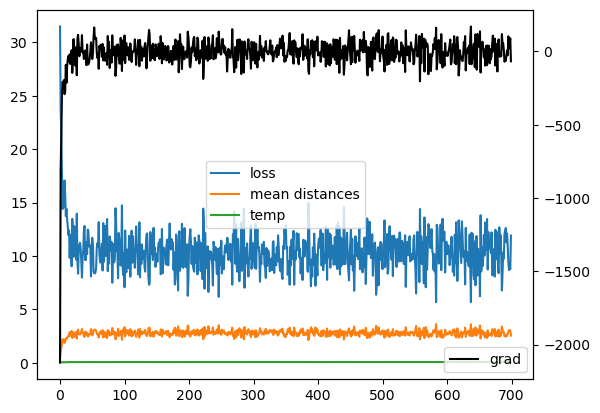

In [21]:
np.arange(len(temps[1:]))
plt.plot(np.arange(len(temps[1:])), losses, label="loss")
plt.plot(np.arange(len(temps[1:])), mean_distances, label="mean distances")
plt.plot(np.arange(len(temps[1:])), temps[1:], label="temp")
plt.legend(loc="center")
axs2 = plt.twinx()
axs2.plot(np.arange(len(temps[1:])), grads, label="grad", color="black")
plt.legend()

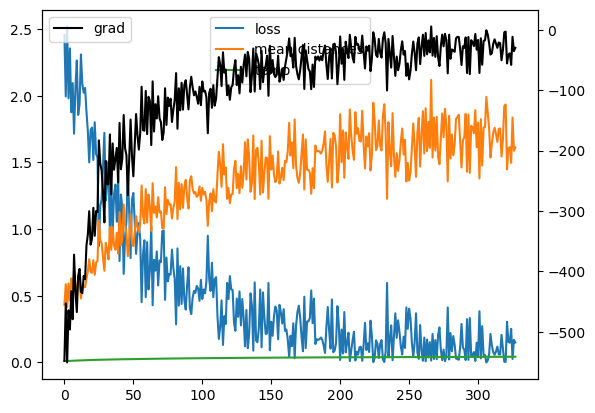

In [14]:
np.arange(len(temps[1:]))
plt.plot(np.arange(len(temps[1:])), losses, label="loss")
plt.plot(np.arange(len(temps[1:])), mean_distances, label="mean distances")
plt.plot(np.arange(len(temps[1:])), temps[1:], label="temp")
plt.legend()
axs2 = plt.twinx()
axs2.plot(np.arange(len(temps[1:])), grads, label="grad", color="black")
plt.legend()